In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [55]:
#file format: 
# timestamp,dhp
# 2015-03-14T08:16:11.300Z,4448.07
# 2015-03-14T08:16:11.378Z,4448.06543
# 2015-03-14T09:04:53.200Z,4447.92
# 2015-03-14T09:04:53.269Z,4447.9165
# or
#Timestamp,DHP
#2013/11/22 20:56:23.463T,0
#2013/11/22 21:44:21.808T,0
#2013/11/22 21:44:21.908T,0
#2013/11/22 22:28:21.395T,0
#2013/11/22 22:28:21.495T,0

def read_and_normalize(file_path):
    # Read CSV file automatically detect header and skip comment lines
    df = pd.read_csv(
        file_path, 
        comment='#',  # skip lines starting with #
        names=['timestamp', 'dhp'],  # column names if no header
        header=0  # first non-comment line as header
    )
    
    # Standardize column names
    df.columns = [col.strip().lower() for col in df.columns]
    df.rename(columns={'dhp': 'dhp', 'timestamp': 'timestamp'}, inplace=True)
    
    # Convert timestamp to pandas datetime, try multiple formats
    df['timestamp'] = pd.to_datetime(
        df['timestamp'], 
        errors='coerce',  # invalid parsing will become NaT
        utc=True,         # convert to UTC if timezone info present
        infer_datetime_format=True
    )
    
    # Drop na
    df = df.dropna(subset=['timestamp'])
    df = df.dropna(subset=['dhp'])

    df['dhp'] = pd.to_numeric(df['dhp'], errors='coerce')
        
    df = df.reset_index(drop=True)
    
    return df

df = read_and_normalize('./well_03_DHP_data..csv')
print(df.head())

C:\Users\Baku\AppData\Local\Temp\ipykernel_13144\3975203069.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(
C:\Users\Baku\AppData\Local\Temp\ipykernel_13144\3975203069.py:29: FutureWarning: Parsed string "2013/11/22 20:56:23.463T" included an un-recognized timezone "T". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['timestamp'] = pd.to_datetime(


                         timestamp  dhp
0 2013-11-22 20:56:23.463000+00:00  0.0
1 2013-11-22 21:44:21.808000+00:00  0.0
2 2013-11-22 21:44:21.908000+00:00  0.0
3 2013-11-22 22:28:21.395000+00:00  0.0
4 2013-11-22 22:28:21.495000+00:00  0.0


In [56]:
# Print statistics for each column
for column in df.columns:
    print(f"Statistics for column '{column}':")
    print(df[column].describe())
    print()

Statistics for column 'timestamp':
count                               18498083
mean     2021-02-14 06:24:36.740993280+00:00
min         2013-11-22 20:56:23.463000+00:00
25%      2019-08-17 05:34:07.549500160+00:00
50%                2020-11-03 23:16:51+00:00
75%      2022-10-05 20:02:47.468499968+00:00
max         2024-10-30 13:10:18.731000+00:00
Name: timestamp, dtype: object

Statistics for column 'dhp':
count    1.849808e+07
mean     2.301341e+03
std      2.828152e+02
min      0.000000e+00
25%      2.140629e+03
50%      2.162450e+03
75%      2.541527e+03
max      9.049812e+03
Name: dhp, dtype: float64



In [57]:
# Print time steps statistics in minutes
df = df.sort_values(by='timestamp')
time_diffs = df['timestamp'].diff().dt.total_seconds().dropna() / 60  # Convert to minutes
print("Time step statistics (in minutes):")
print(time_diffs.describe())

Time step statistics (in minutes):
count    1.849808e+07
mean     3.109692e-01
std      3.194985e+00
min      1.666667e-05
25%      5.183333e-03
50%      8.275000e-02
75%      2.344833e-01
max      3.904995e+03
Name: timestamp, dtype: float64


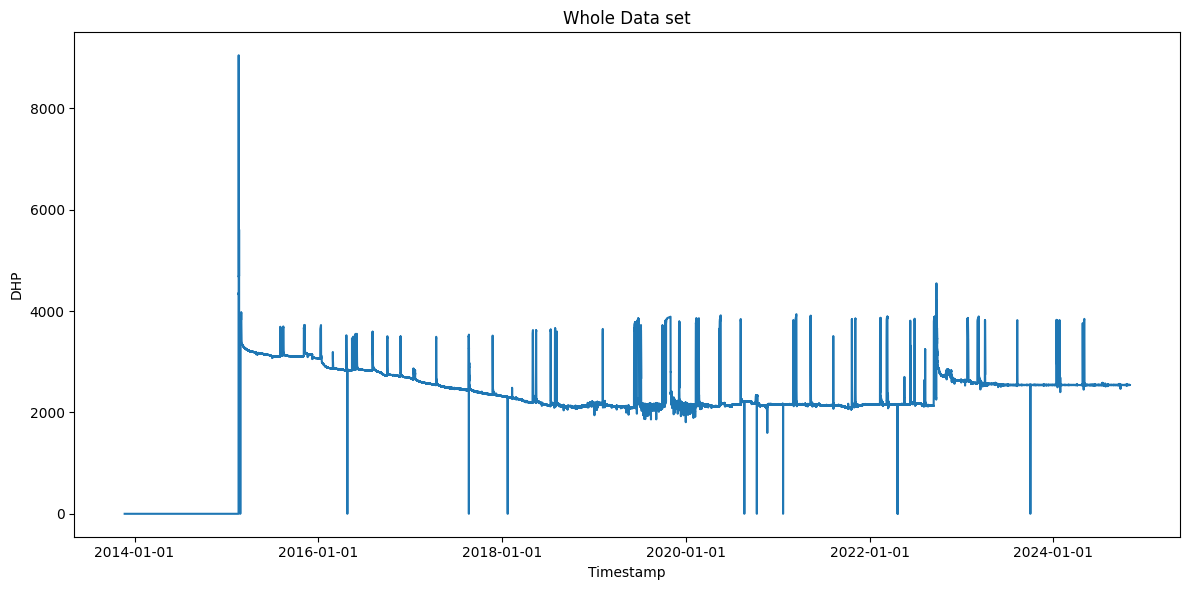

In [58]:
# Visualize whole dataset
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['dhp'])
plt.xlabel('Timestamp')
plt.ylabel('DHP')
plt.title('Whole Data set')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.tight_layout()
plt.show()

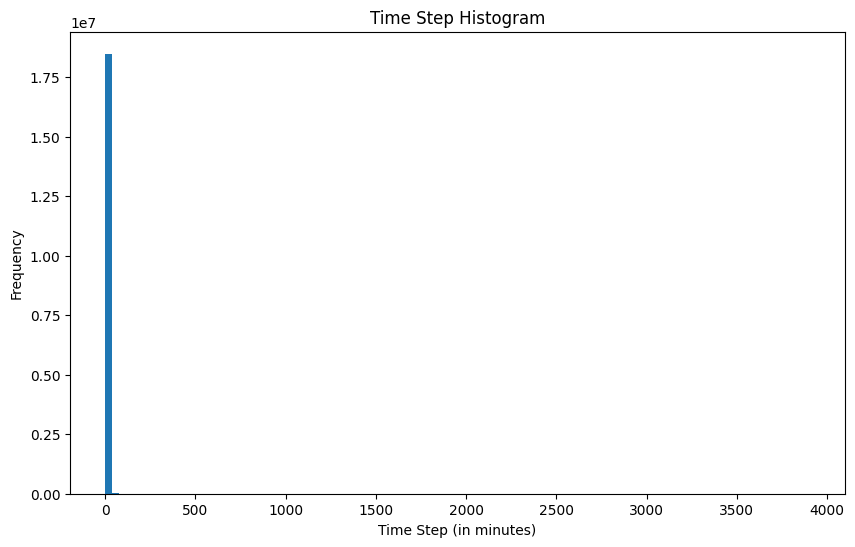

In [59]:
# Plot the time step histogram
plt.figure(figsize=(10, 6))
plt.hist(time_diffs, bins=100)
plt.xlabel('Time Step (in minutes)')
plt.ylabel('Frequency')
plt.title('Time Step Histogram')
plt.show()

In [60]:
# Find the index of -infinity and NaN valus for dhp
inf_indices = df.index[np.isinf(df['dhp'])]
nan_indices = df.index[np.isnan(df['dhp'])]
print("Indices of -infinity and NaN values in 'dhp' column:", inf_indices, nan_indices)

Indices of -infinity and NaN values in 'dhp' column: Index([], dtype='int64') Index([], dtype='int64')


In [61]:
# Create new dataframe without -infinity and values below 100 for dhp
df_clean = df[~np.isinf(df['dhp'])]
df_clean = df_clean[df_clean['dhp'] >= 100]


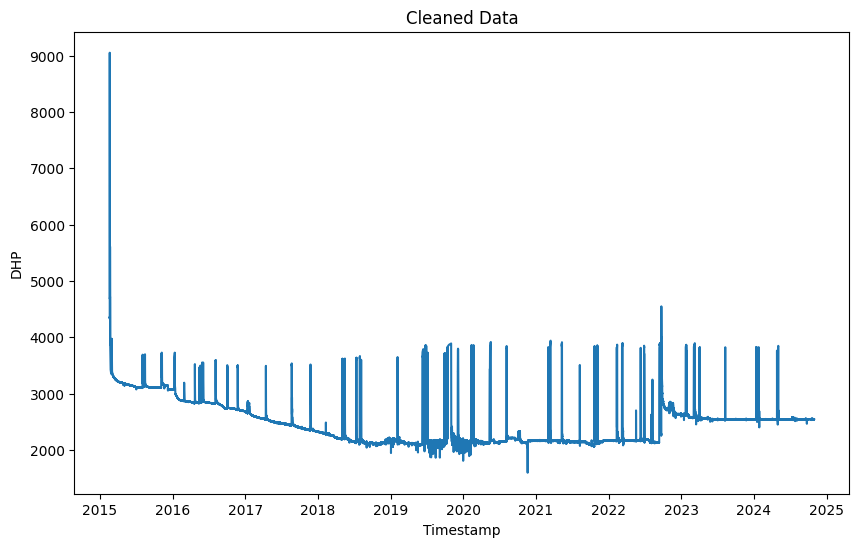

In [62]:
# Visualize the entire cleaned dataset
plt.figure(figsize=(10, 6))
plt.plot(df_clean['timestamp'], df_clean['dhp'])
plt.xlabel('Timestamp')
plt.ylabel('DHP')
plt.title('Cleaned Data')
plt.show()

In [63]:
# Statistics for pressure data after cleaning
print("Statistics for 'dhp' column after cleaning:")
print(df_clean['dhp'].describe()) 

Statistics for 'dhp' column after cleaning:
count    1.848716e+07
mean     2.302701e+03
std      2.773081e+02
min      1.595958e+03
25%      2.140660e+03
50%      2.162456e+03
75%      2.541529e+03
max      9.049812e+03
Name: dhp, dtype: float64


In [64]:
# Print neighbors of max dhp value
max_dhp_index = df_clean['dhp'].idxmax()
start_index = max(0, max_dhp_index - 5)
end_index = min(len(df_clean) - 1, max_dhp_index + 5)
print("Neighbors of maximum 'dhp' value after cleaning:")
print(df_clean.loc[start_index:end_index])

Neighbors of maximum 'dhp' value after cleaning:
                             timestamp       dhp
11874 2015-02-19 02:00:03.540000+00:00  8984.592
11875 2015-02-19 02:00:08.547000+00:00  9032.428
11876 2015-02-19 02:00:13.633000+00:00  9044.960
11877 2015-02-19 02:00:18.641000+00:00  9045.717
11878 2015-02-19 02:00:23.664000+00:00  9049.131
11879 2015-02-19 02:00:28.765000+00:00  9049.812
11880 2015-02-19 02:00:33.804000+00:00  9032.518
11881 2015-02-19 02:00:38.858000+00:00  9028.622
11882 2015-02-19 02:00:44.006000+00:00  9049.226
11883 2015-02-19 02:00:49.076000+00:00  9049.128
11884 2015-02-19 02:00:54.100000+00:00  9043.396


In [65]:
# Show index of maximum dhp value and datetime and dhp value
# Remove values below 1000 psi and above 5000 psi
df_clean = df_clean[(df_clean['dhp'] >= 1000) & (df_clean['dhp'] <= 5000)]
max_dhp_index = df_clean['dhp'].idxmax()
print("Index of maximum 'dhp' value after cleaning:", max_dhp_index)
print("Datetime of maximum 'dhp' value after cleaning:", df_clean.loc[max_dhp_index, 'timestamp'])
print("DHP value at maximum index:", df_clean.loc[max_dhp_index, 'dhp'])

Index of maximum 'dhp' value after cleaning: 10941
Datetime of maximum 'dhp' value after cleaning: 2015-02-19 00:36:02.048000+00:00
DHP value at maximum index: 4999.574


In [66]:
# Show the neighbors of the maximum dhp value
print("Neighbors of maximum 'dhp' value after cleaning:")
print(df_clean.loc[max_dhp_index-1:max_dhp_index+1])

Neighbors of maximum 'dhp' value after cleaning:
                             timestamp       dhp
10940 2015-02-19 00:35:56.978000+00:00  4956.356
10941 2015-02-19 00:36:02.048000+00:00  4999.574


In [67]:
# Fix the decimal shift issue if it occurs again with logarithmic scale
df_fixed = df_clean.copy()
p = df_fixed["dhp"]
# Global outlier detection
log_p = np.log10(p)
median_log = log_p.median()
global_mask = (log_p - median_log).abs() >= 1.0
prev_p = p.shift(1)
next_p = p.shift(-1)
# Local outlier detection
local_mask = (p > 5 * prev_p) & (p > 5 * next_p)
fix_mask = global_mask | local_mask
df_fixed.loc[fix_mask, "dhp"] = df_fixed.loc[fix_mask, "dhp"] / 10
df_fixed["dhp_decimal_fixed"] = fix_mask
max_dhp_index = df_fixed['dhp'].idxmax()

print("Index of maximum 'dhp' value after fixing decimal shift:", max_dhp_index)
print("Datetime of maximum 'dhp' value after fixing decimal shift:", df_fixed.loc[max_dhp_index, 'timestamp'])
print("DHP value at maximum index:", df_fixed.loc[max_dhp_index, 'dhp'])

Index of maximum 'dhp' value after fixing decimal shift: 10941
Datetime of maximum 'dhp' value after fixing decimal shift: 2015-02-19 00:36:02.048000+00:00
DHP value at maximum index: 4999.574


(first well data)

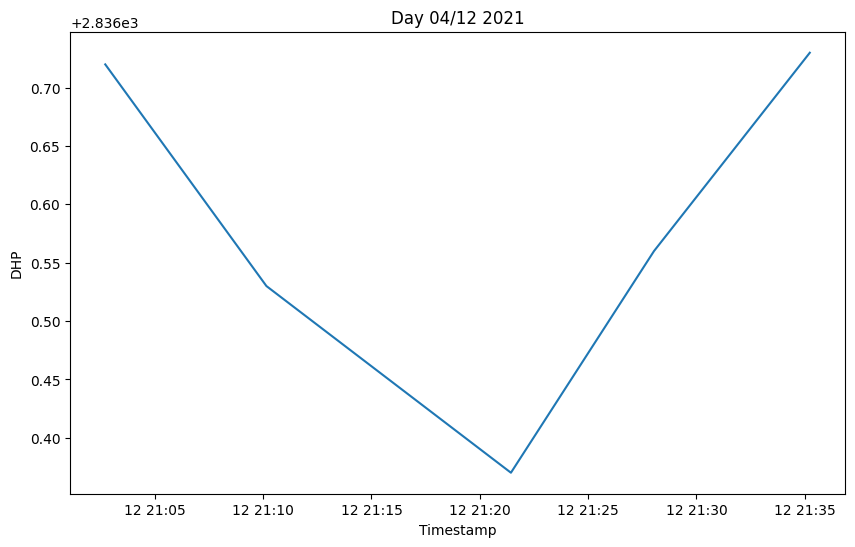

In [68]:
from scipy.signal import savgol_filter, medfilt, butter, filtfilt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import TheilSenRegressor, LinearRegression
from sklearn.utils import resample

df_fixed = df_fixed.sort_index()
dhp = df_fixed["dhp"].values
time_index = np.arange(len(dhp)) 
# Quantile clipping
q_low, q_high = 0.01, 0.99
q_l, q_h = np.quantile(dhp, [q_low, q_high])
dhp_quantile = np.clip(dhp, q_l, q_h)
df_fixed['dhp_quantile'] = dhp_quantile

start_time = pd.to_datetime('2016-04-12T21:00:00.000Z', format='ISO8601')
end_time = pd.to_datetime('2016-04-12T21:59:59.999Z', format='ISO8601')
mask = (df_fixed['timestamp'] >= start_time) & (df_fixed['timestamp'] <= end_time)
df_subset = df_fixed.loc[mask]
plt.figure(figsize=(10, 6))
plt.plot(df_subset['timestamp'], df_subset['dhp_quantile'])
plt.xlabel('Timestamp')
plt.ylabel('DHP')
plt.title('Day 04/12 2021')
plt.show()


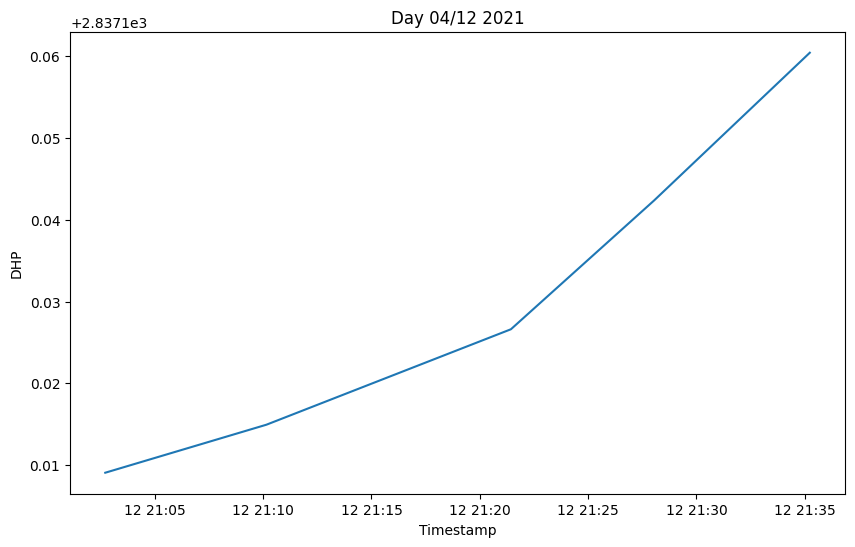

In [69]:
from scipy.ndimage import grey_opening, grey_closing
y = df["dhp"].values
WINDOW = 11   # must be odd

y_upper = grey_closing(y, size=WINDOW)

df["dhp_upper_envelope"] = y_upper

# smooth with Savitzky–Golay
SG_WINDOW = 21   # odd
SG_ORDER = 3

df["dhp_upper_smooth"] = savgol_filter(
    df["dhp_upper_envelope"], 
    window_length=SG_WINDOW, 
    polyorder=SG_ORDER
)

df_fixed['dhp_morph'] = df["dhp_upper_smooth"]

# Plot the morphological filtered data
start_time = pd.to_datetime('2016-04-12T21:00:00.000Z', format='ISO8601')
end_time = pd.to_datetime('2016-04-12T21:59:59.999Z', format='ISO8601')
mask = (df_fixed['timestamp'] >= start_time) & (df_fixed['timestamp'] <= end_time)
df_subset = df_fixed.loc[mask]
plt.figure(figsize=(10, 6))
plt.plot(df_subset['timestamp'], df_subset['dhp_morph'])
plt.xlabel('Timestamp')
plt.ylabel('DHP')
plt.title('Day 04/12 2021')
plt.show()

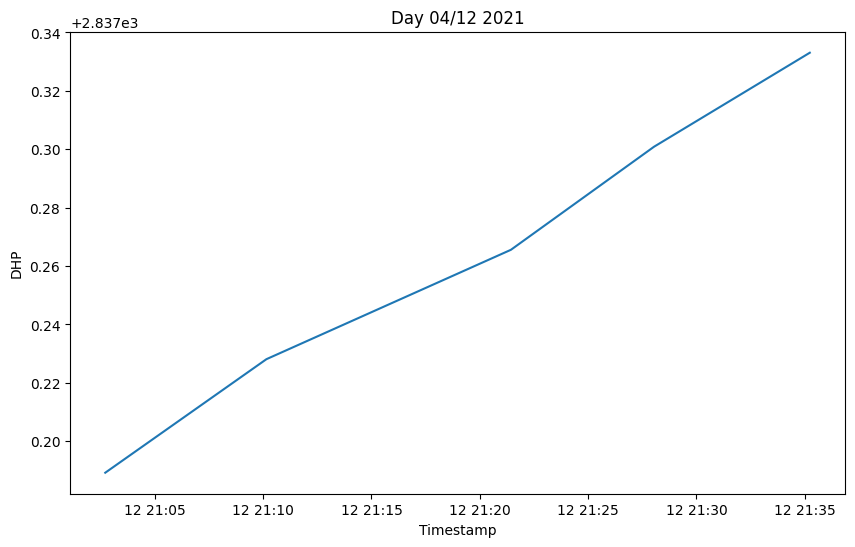

In [70]:
window_length = 51 if len(dhp) > 51 else len(dhp)//2*2+1  # must be odd
polyorder = 3
df_fixed['dhp_savgol'] = savgol_filter(df_fixed['dhp_morph'], window_length, polyorder)

# Plot the Savitzky-Golay filtered data
start_time = pd.to_datetime('2016-04-12T21:00:00.000Z', format='ISO8601')
end_time = pd.to_datetime('2016-04-12T21:59:59.999Z', format='ISO8601')
mask = (df_fixed['timestamp'] >= start_time) & (df_fixed['timestamp'] <= end_time)
df_subset = df_fixed.loc[mask]
plt.figure(figsize=(10, 6))
plt.plot(df_subset['timestamp'], df_subset['dhp_savgol'])
plt.xlabel('Timestamp')
plt.ylabel('DHP')
plt.title('Day 04/12 2021')
plt.show()

In [71]:
df_final = df_fixed.copy()
df_final['dhp'] = df_final['dhp_savgol']

SECTION 1

In [72]:
# TIME WINDOW 

MIN_DT_HR = 1.0 / 60.0
df = df_final.copy()

dhp = df["dhp"].values
time_arr = df["timestamp"].values

dt_vals = df["timestamp"].diff().dt.total_seconds().values / 3600
dt_vals = np.maximum(dt_vals, MIN_DT_HR)
dt_eff_hr = np.nanmedian(dt_vals)

# 2. DERIVATIVES
dp = np.diff(dhp)
dt_safe = np.where(dt_vals[1:] <= 0, dt_eff_hr, dt_vals[1:])

dpdt = np.zeros(len(dhp))
dpdt[1:] = dp / dt_safe

dpdt_smooth = (
    pd.Series(dpdt)
    .ewm(alpha=0.05, adjust=False)
    .mean()
    .values
)

# STA/LTA
abs_dpdt = np.abs(dpdt)

sta = pd.Series(abs_dpdt).ewm(alpha=0.01, adjust=False).mean().values
lta = pd.Series(abs_dpdt).ewm(alpha=0.005, adjust=False).mean().values

sta_lta = np.divide(sta, lta, out=np.zeros_like(sta), where=lta != 0)

start_mask = (sta_lta > 1.2) & (dpdt_smooth > 2.0)


# END DETECTION

NEG_SLOPE_THRESH = -3.0
NEG_STABLE_HR = 2.0
CONFIRM_SLOPE = -1.5

SHORT_LOOK_FWD_HR = 0.5
END_VERIFY_HR = 1.5
NO_BUILDUP_MARGIN = 600

NOISE_TOLERANCE_PSI = 20
PLATEAU_LOOKBACK_HR = 2.0

RECOVERY_LOOKAHEAD_HR = 4.0
RECOVERY_MARGIN_PSI = 200

MEAN_NEG_SLOPE_KEEP = -0.8   

neg_mask = dpdt_smooth < NEG_SLOPE_THRESH
confirm_mask = dpdt_smooth < CONFIRM_SLOPE

# EVENT FILTER PARAMETERS
MIN_DURATION_HR = 2.0
MIN_DELTA_P = 100

CONFIRM_WINDOW_HR = 3.0
CONFIRM_DELTA_P = 400

COOLDOWN_HR = 3.0

# START VALIDATION — SLOPE + ADAPTIVE PROJECTION
START_MIN_POS_SLOPE = 0.5
START_PROJECTED_MIN_DP = 600.0

DEFAULT_PROJECTION_HR = 24.0
MAX_PROJECTION_HR = 48.0
MIN_PROJECTION_HR = 2.0

# STATE
events = []

IDLE, PROBATION, IN_EVENT, COOLDOWN = 0, 1, 2, 3
state = IDLE

start_idx = None
start_pressure = None
p_max = None
neg_time = 0.0

prev_pbu_end_idx = None  

confirm_deadline = None
cooldown_until = None

# START MEAN-DELTA PARAMETERS
FORWARD_START_OFFSET_HR = 1.0
FORWARD_WINDOW_HR = 2.0    
EXTENDED_FORWARD_HR = 4.0    


i = 0
N = len(dhp)

while i < N:

    # IDLE 
    if state == IDLE and start_mask[i]:

        slope_now = dpdt_smooth[i]


        if slope_now <= START_MIN_POS_SLOPE:
            i += 1
            continue


        # ADAPTIVE PROJECTION HORIZON
        if len(events) > 0:
            median_dur = np.median([e["duration_hr"] for e in events])
            projection_hr = float(
                np.clip(median_dur, MIN_PROJECTION_HR, MAX_PROJECTION_HR)
            )
        else:
            projection_hr = DEFAULT_PROJECTION_HR

        projected_dp = slope_now * projection_hr

        if projected_dp < START_PROJECTED_MIN_DP:
            i += 1
            continue

        # BASELINE: previous PBU end until now

        t_now = time_arr[i]

        # baseline
        if prev_pbu_end_idx is not None:
            j0 = prev_pbu_end_idx
        else:
            j0 = 0

        j1 = i
        baseline_segment = dhp[j0:j1]

        if j1 > j0 and len(baseline_segment) > 3:
            baseline_slope = np.mean(dpdt_smooth[j0:j1])
        else:
            baseline_slope = 0

        # if baseline is declining rapidly, relax mean
        if baseline_slope < -1.0:
            print(
                f"[INFO] baseline falling ({baseline_slope:.2f} psi/hr) — "
                f"relaxing baseline mean"
            )
            baseline_mean = dhp[j1-1]
        else:
            baseline_mean = (
                np.mean(baseline_segment) if j1 > j0 else dhp[i]
            )

        # forward region initial window
        fwd_start = t_now + np.timedelta64(int(FORWARD_START_OFFSET_HR*3600), "s")
        fwd_end   = t_now + np.timedelta64(int((FORWARD_START_OFFSET_HR+FORWARD_WINDOW_HR)*3600), "s")

        k0 = np.searchsorted(time_arr, fwd_start)
        k1 = np.searchsorted(time_arr, fwd_end)

        if k1 > k0:
            forward_mean = np.mean(dhp[k0:k1])
        else:
            forward_mean = dhp[i]

        mean_delta = forward_mean - baseline_mean

        # mean delta slope-aware
        adaptive_delta_req = max(
            10.0,                  # allow very weak early rise
            10.0 + 4.0 * slope_now # slower slope allow softer requirement
        )

        # If projection is very strong, bypass deltamean entirely
        if projected_dp >= 800:
            adaptive_delta_req = 5.0


        # IF FAILS EXTEND WINDOW
        if mean_delta < adaptive_delta_req:

            fwd_end_ext = t_now + np.timedelta64(int(EXTENDED_FORWARD_HR * 3600), "s")
            k1_ext = np.searchsorted(time_arr, fwd_end_ext)

            if k1_ext > k0:
                forward_mean_ext = np.mean(dhp[k0:k1_ext])
                mean_delta_ext = forward_mean_ext - baseline_mean
            else:
                mean_delta_ext = mean_delta

            if mean_delta_ext < adaptive_delta_req:
                print(
                    f"[REJECT START] Δmean short={mean_delta:.1f}, "
                    f"extended={mean_delta_ext:.1f} "
                    f"(need ≥ {adaptive_delta_req:.1f})"
                )
                i += 1
                continue

            print(
                f"[PASS EXTENDED] weak early rise — "
                f"Δmean(4h)={mean_delta_ext:.1f} psi "
                f"(threshold {adaptive_delta_req:.1f})"
            )
            mean_delta = mean_delta_ext

        # ACCEPT START CANDIDATE

        print(
            f"[START] {time_arr[i]} "
            f"P={dhp[i]:.1f} psi "
            f"slope={slope_now:.2f} psi/hr "
            f"Δmean={mean_delta:.1f} psi (adaptive ok)"
        )

        start_idx = i
        start_pressure = dhp[i]
        p_max = dhp[i]
        neg_time = 0.0

        confirm_deadline = (
            time_arr[i]
            + np.timedelta64(int(CONFIRM_WINDOW_HR * 3600), "s")
        )

        state = PROBATION

    # PROBATION
    elif state == PROBATION:

        p_max = max(p_max, dhp[i])

        if p_max >= start_pressure + CONFIRM_DELTA_P:
            print("[PASS] Event confirmed")
            state = IN_EVENT

        elif time_arr[i] >= confirm_deadline:
            print("[REJECT] Probation timeout")
            state = IDLE

    # IN EVENT: Finding maximum pressure in event and checking for end
    elif state == IN_EVENT:

        p_max = max(p_max, dhp[i])

        if neg_mask[i]:
            neg_time += dt_vals[i]
        else:
            neg_time = 0.0

        # END CANDIDATE
        if neg_time >= NEG_STABLE_HR and confirm_mask[i]:

            back_mask = (
                (time_arr <= time_arr[i]) &
                (time_arr >= time_arr[i] -
                 np.timedelta64(int(NEG_STABLE_HR * 3600), 's'))
            )

            idx_range = np.where(back_mask)[0]
            end_idx = idx_range[np.argmin(dpdt_smooth[idx_range])]
            end_pressure = dhp[end_idx]

            print(f"[END?] Candidate end at {time_arr[end_idx]} "
                  f"P_end={end_pressure:.1f} psi")

            # ignore noise
            plateau_back = (
                (time_arr < time_arr[end_idx]) &
                (time_arr >= time_arr[end_idx] -
                 np.timedelta64(int(PLATEAU_LOOKBACK_HR * 3600), "s"))
            )

            plateau_level = (
                np.median(dhp[plateau_back]) if plateau_back.any()
                else dhp[end_idx]
            )

            dip_size = plateau_level - end_pressure

            if dip_size <= NOISE_TOLERANCE_PSI:
                print(f"[REJECT] Noise dip ({dip_size:.1f} psi)")
                neg_time = 0.0
                i += 1
                continue

            # check short term slope forward
            short_until = (
                time_arr[end_idx]
                + np.timedelta64(int(SHORT_LOOK_FWD_HR * 3600), "s")
            )

            short_mask = (time_arr > time_arr[end_idx]) & (time_arr <= short_until)

            mean_future_slope = (
                np.mean(dpdt_smooth[short_mask]) if short_mask.any()
                else dpdt_smooth[end_idx]
            )

            if mean_future_slope > 0:
                print(
                    f"[REJECT] Bounce-back slope "
                    f"+{mean_future_slope:.2f} psi/hr — still in buildup"
                )
                neg_time = 0.0
                i += 1
                continue

            # check for recovery
            recovery_until = (
                time_arr[end_idx]
                + np.timedelta64(int(RECOVERY_LOOKAHEAD_HR * 3600), "s")
            )

            rec_mask = (time_arr > time_arr[end_idx]) & (time_arr <= recovery_until)

            if rec_mask.any():
                max_after_end = np.max(dhp[rec_mask])
                mean_recovery_slope = np.mean(dpdt_smooth[rec_mask])
            else:
                max_after_end = end_pressure
                mean_recovery_slope = 0

            if (
                max_after_end >= (p_max - RECOVERY_MARGIN_PSI)
                and mean_recovery_slope > MEAN_NEG_SLOPE_KEEP
            ):
                print(
                    f"[REJECT] Recovery rise detected "
                    f"P_after={max_after_end:.1f} psi "
                    f"slope={mean_recovery_slope:.2f} psi/hr"
                )
                neg_time = 0.0
                i += 1
                continue

            # LONG WINDOW must not rebuild
            verify_until = (
                time_arr[end_idx]
                + np.timedelta64(int(END_VERIFY_HR * 3600), "s")
            )

            future_mask = (time_arr > time_arr[end_idx]) & (time_arr <= verify_until)

            max_future_p = (
                np.max(dhp[future_mask]) if future_mask.any()
                else end_pressure
            )

            if max_future_p >= end_pressure + NO_BUILDUP_MARGIN:
                print(
                    f"[REJECT] Pressure rebuilt after end candidate "
                    f"(+{max_future_p - end_pressure:.1f} psi)"
                )
                neg_time = 0.0
                i += 1
                continue

            # FINAL ACCEPTANCE
            duration_hr = (
                (time_arr[end_idx] - time_arr[start_idx])
                / np.timedelta64(1, "h")
            )

            delta_p = p_max - start_pressure

            if duration_hr >= MIN_DURATION_HR and delta_p >= MIN_DELTA_P:

                print(
                    f"[ACCEPT] PBU event {time_arr[start_idx]} "
                    f"→ {time_arr[end_idx]} "
                    f"duration={duration_hr:.2f} hr "
                    f"ΔP={delta_p:.1f} psi"
                )

                events.append({
                    "pbu_start": time_arr[start_idx],
                    "pbu_end": time_arr[end_idx],
                    "duration_hr": float(duration_hr),
                    "delta_p_psi": float(delta_p)
                })

                cooldown_until = (
                    time_arr[end_idx]
                    + np.timedelta64(int(COOLDOWN_HR * 3600), "s")
                )

                state = COOLDOWN

            else:
                print(
                    f"[REJECT] Failed final thresholds "
                    f"duration={duration_hr:.2f} hr "
                    f"ΔP={delta_p:.1f} psi "
                    f"(min {MIN_DURATION_HR} hr / {MIN_DELTA_P} psi)"
                )
                state = IDLE

    # COOLDOWN
    elif state == COOLDOWN:

        if time_arr[i] >= cooldown_until:
            print(f"[COOLDOWN END] Resume detection at {time_arr[i]}")
            state = IDLE

    # COOLDOWN
    elif state == COOLDOWN and time_arr[i] >= cooldown_until:
        state = IDLE

    i += 1


# RESULTS
events_df = pd.DataFrame(events)

print("\nSUMMARY FILTER")

if len(events_df) == 0:
    print("No raw PBU events detected by state machine.")
else:
    print(f"Detected {len(events_df)} raw PBU candidates")

    events_df = events_df[
        (events_df["duration_hr"] >= 2.0) &
        (events_df["delta_p_psi"] >= 600)
    ].reset_index(drop=True)

    print(f"{len(events_df)} final valid PBU events retained")

print(events_df)


[START] 2015-02-18T12:46:56.935000000 P=3663.7 psi slope=370.56 psi/hr Δmean=511.2 psi (adaptive ok)
[PASS] Event confirmed
[END?] Candidate end at 2015-02-20T15:31:29.918000000 P_end=4436.6 psi
[REJECT] Bounce-back slope +24.44 psi/hr — still in buildup
[END?] Candidate end at 2015-02-20T15:31:29.918000000 P_end=4436.6 psi
[REJECT] Bounce-back slope +24.44 psi/hr — still in buildup
[END?] Candidate end at 2015-02-20T15:31:29.918000000 P_end=4436.6 psi
[REJECT] Bounce-back slope +24.44 psi/hr — still in buildup
[END?] Candidate end at 2015-02-20T15:31:29.918000000 P_end=4436.6 psi
[REJECT] Bounce-back slope +24.44 psi/hr — still in buildup
[END?] Candidate end at 2015-02-20T17:12:52.088000000 P_end=4069.1 psi
[ACCEPT] PBU event 2015-02-18T12:46:56.935000000 → 2015-02-20T17:12:52.088000000 duration=52.43 hr ΔP=1327.6 psi
[COOLDOWN END] Resume detection at 2015-02-20T20:15:34.180000000
[INFO] baseline falling (-1.99 psi/hr) — relaxing baseline mean
[REJECT START] Δmean short=-39.3, exten

In [73]:
# Add PBU start/end intervals

INTERVAL_HR = 1.5

if len(events_df) > 0:

    events_df["interval_start"] = (
        events_df["pbu_start"]
        - np.timedelta64(int(INTERVAL_HR * 3600), "s")
    )

    events_df["interval_end"] = (
        events_df["pbu_end"]
        + np.timedelta64(int(INTERVAL_HR * 3600), "s")
    )


else:
    print("No events")

display(events_df)

pbu_start                 pbu_end  duration_hr  delta_p_psi  \
0  2015-02-18 12:46:56.935 2015-02-20 17:12:52.088    52.431987  1327.585599   
1  2015-02-26 22:13:42.721 2015-03-01 11:31:43.625    61.300251   614.950547   
2  2015-11-04 16:56:11.900 2015-11-07 23:21:20.200    78.418972   602.719407   
3  2016-04-21 20:30:56.300 2016-04-22 04:22:12.500     7.854500   677.164326   
4  2016-05-14 08:56:46.200 2016-05-14 20:56:33.900    11.996583   610.506536   
5  2016-05-19 11:04:39.400 2016-05-19 14:20:52.000     3.270167   630.522041   
6  2016-05-25 18:52:50.500 2016-05-26 01:17:33.700     6.412000   631.349944   
7  2016-05-28 00:53:57.700 2016-05-28 09:57:14.000     9.054528   665.205935   
8  2016-06-02 10:09:18.900 2016-06-02 20:03:10.200     9.897583   667.986018   
9  2016-08-02 22:38:21.800 2016-08-04 15:23:38.700    40.754694   650.462788   
10 2016-10-01 08:32:48.200 2016-10-02 04:28:11.800    19.923222   750.620716   
11 2016-11-22 17:53:56.600 2016-11-23 14:22:45.600    20.480278   778.216688   
12 2017-04-13 10:53:57.700 2017-04-14 04:47:58.800    17.900306   936.133674   
13 2017-08-21 04:43:45.600 2017-08-22 02:57:12.100    22.224028  1075.730477   
14 2017-11-23 23:41:24.500 2017-11-24 12:11:58.600    12.509472  1146.022630   
15 2018-05-02 00:51:59.600 2018-05-03 16:44:10.000    39.869556  1410.855192   
16 2018-05-15 14:58:48.400 2018-05-16 05:08:53.100    14.167972  1408.859318   
17 2018-07-12 12:04:04.700 2018-07-13 07:09:26.500    19.089389  1491.581500   
18 2018-07-29 16:42:56.000 2018-07-30 20:33:59.900    27.851083  1512.788359   
19 2018-08-05 16:19:57.200 2018-08-06 02:11:06.700     9.852639  1409.719759   
20 2019-02-04 15:23:15.800 2019-02-05 08:46:00.869    17.379186  1514.954723   
21 2019-06-09 02:38:19.300 2019-06-14 01:23:07.300   118.746667  1647.476497   
22 2019-06-20 15:27:49.023 2019-06-28 20:50:56.200   197.385327  1702.257679   
23 2019-07-06 14:58:16.740 2019-07-06 23:08:21.000     8.167850  1542.631829   
24 2019-09-29 16:48:34.212 2019-09-30 08:11:05.800    15.375441  1570.086948   
25 2019-10-11 01:53:06.200 2019-10-13 07:26:43.100    53.560250  1636.869026   
26 2019-10-14 12:03:17.945 2019-11-01 10:56:27.800   430.886071  1568.133253   
27 2019-12-04 19:25:02.000 2019-12-06 02:21:11.844    30.936068  1606.698327   
28 2020-02-09 14:14:13.000 2020-02-12 05:07:41.043    62.891123  1743.055087   
29 2020-02-16 06:35:12.000 2020-02-17 12:46:38.591    30.190720  1645.237852   
30 2020-02-20 16:47:19.700 2020-02-22 03:40:43.711    34.890003  1688.802909   
31 2020-05-14 08:21:07.700 2020-05-18 22:47:40.773   110.442520  1747.592768   
32 2020-08-05 13:22:48.600 2020-08-06 10:25:05.142    21.037928  1640.304494   
33 2021-03-03 04:37:34.464 2021-03-03 15:08:00.000    10.507093  1621.913180   
34 2021-03-11 14:44:08.497 2021-03-15 17:54:25.000    99.171251  1768.299128   
35 2021-05-10 01:41:31.542 2021-05-11 17:42:25.000    40.014849  1737.748037   
36 2021-08-09 03:13:19.000 2021-08-09 07:39:30.681     4.436578  1367.546387   
37 2021-10-21 11:23:53.000 2021-10-22 10:05:47.434    22.698454  1764.754103   
38 2021-11-03 23:05:43.549 2021-11-05 02:29:08.000    27.390125  1719.872461   
39 2022-02-10 18:03:29.000 2022-02-11 10:10:26.000    16.115833  1649.943052   
40 2022-02-12 02:38:36.221 2022-02-13 01:44:03.000    23.090772  1443.674672   
41 2022-03-08 21:24:06.000 2022-03-12 12:29:43.561    87.093767  1718.840045   
42 2022-06-10 21:45:07.121 2022-06-11 07:55:27.000    10.172189  1640.330607   
43 2022-06-27 15:49:53.000 2022-06-28 16:58:28.288    25.143136  1667.505119   
44 2022-08-08 21:18:23.000 2022-08-09 12:39:31.000    15.352222  1053.236799   
45 2022-09-12 11:27:05.000 2022-09-17 17:20:41.000   125.893333  1718.566954   
46 2022-09-19 05:25:48.000 2022-09-20 23:13:42.648    41.798513  1567.368061   
47 2022-09-22 16:35:08.000 2022-09-23 07:25:49.751    14.844931  2254.007932   
48 2023-01-23 04:58:37.000 2023-01-26 10:53:42.000    77.918056  1235.840715   
49 2023-03-04 19:

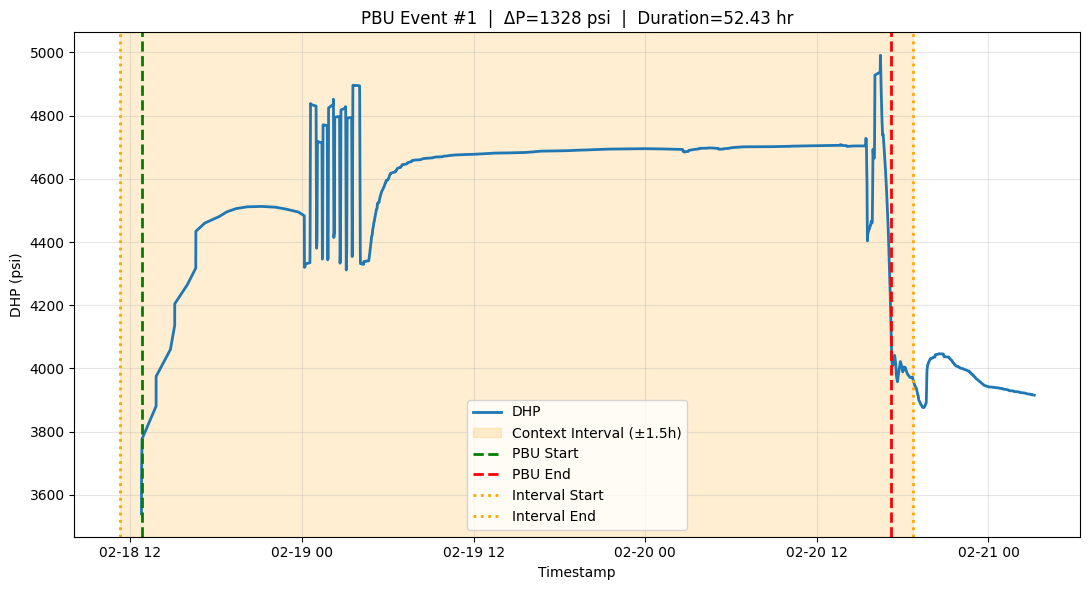

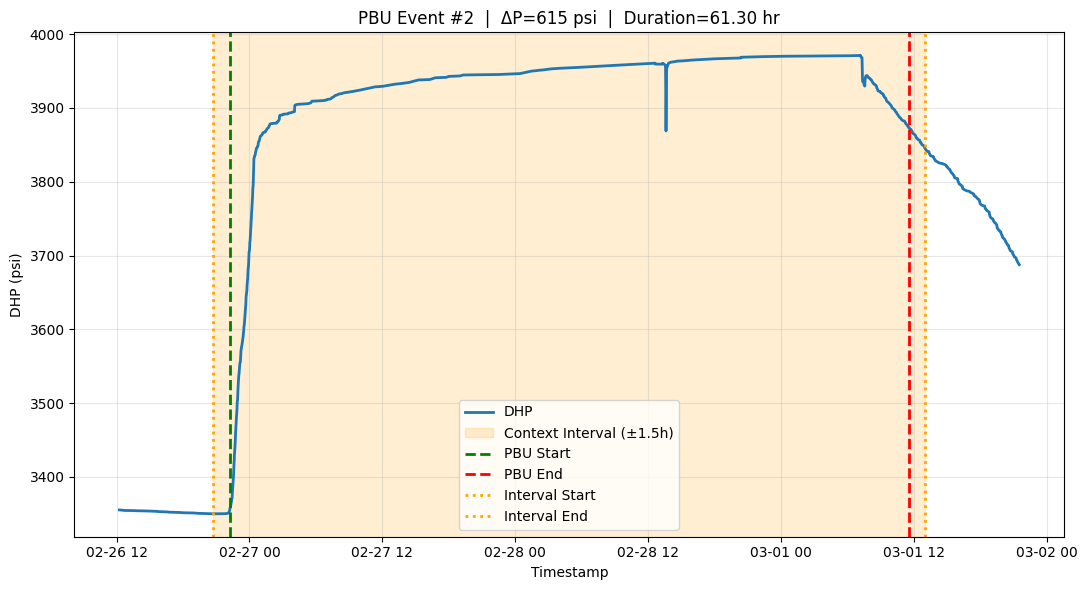

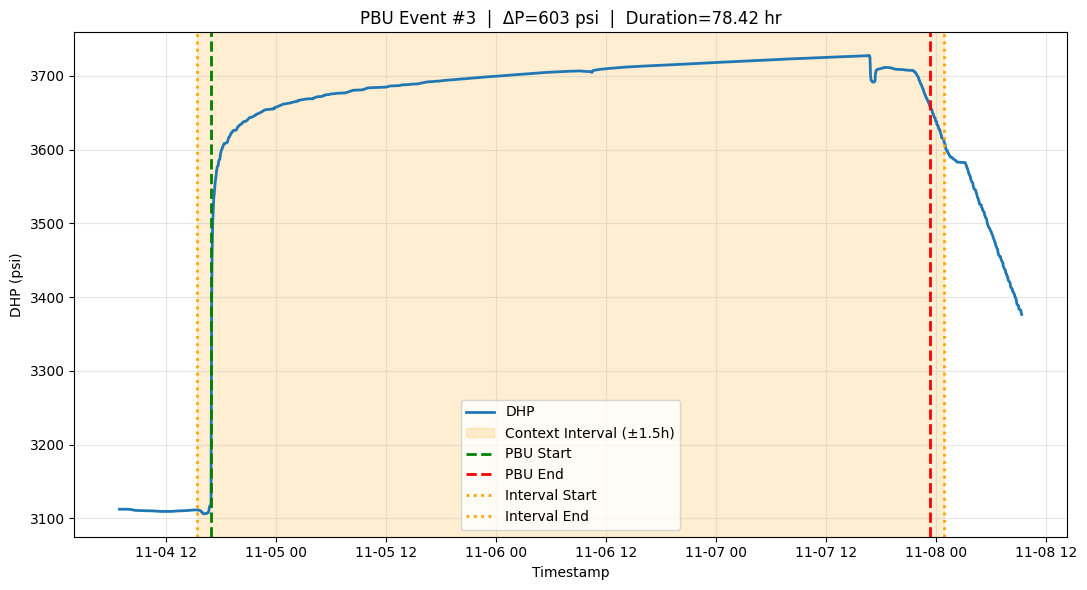

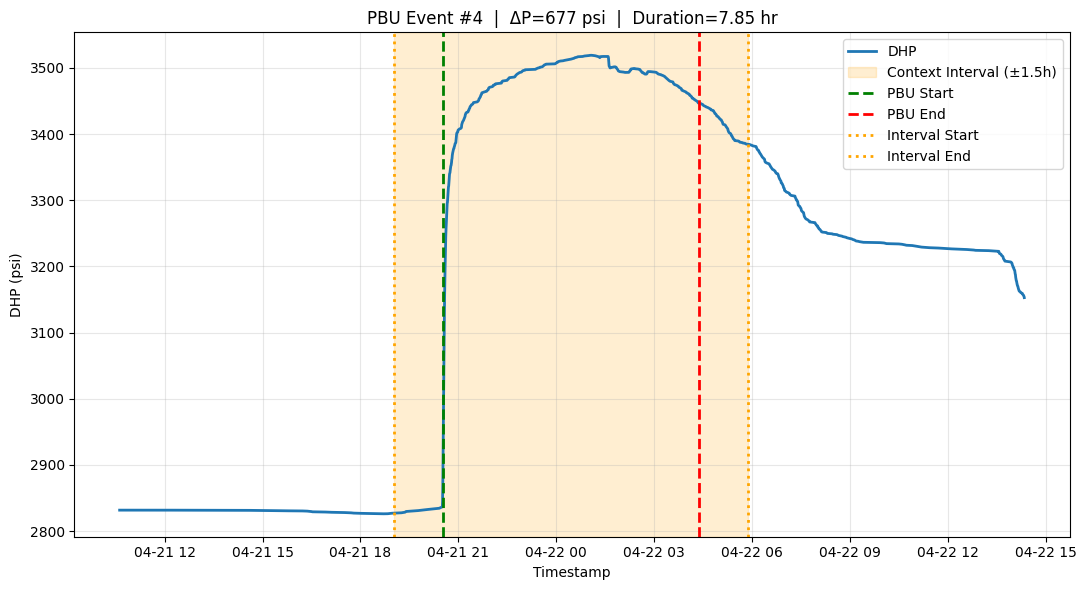

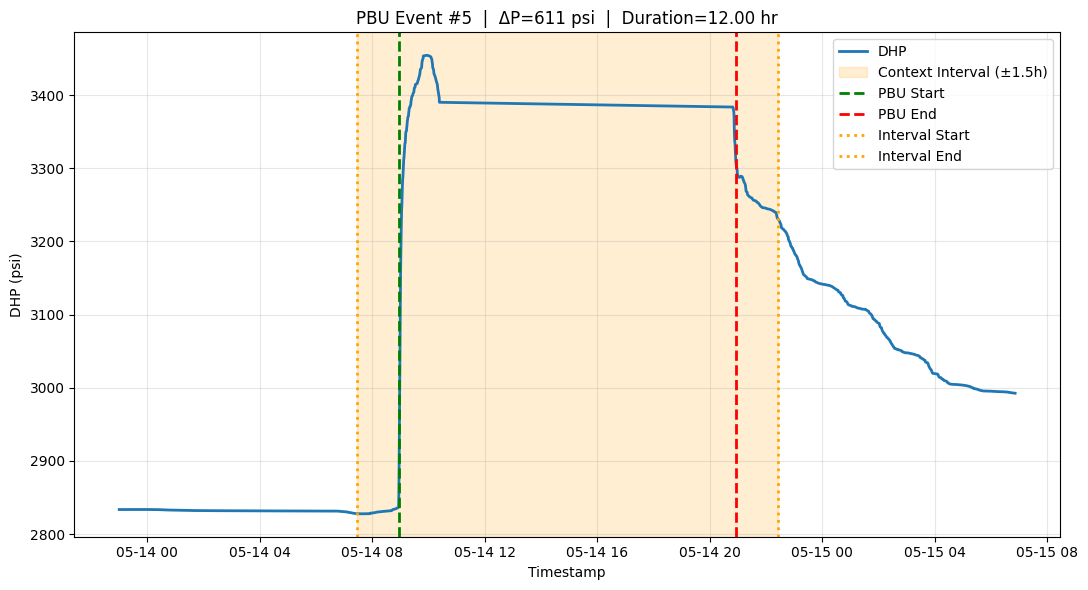

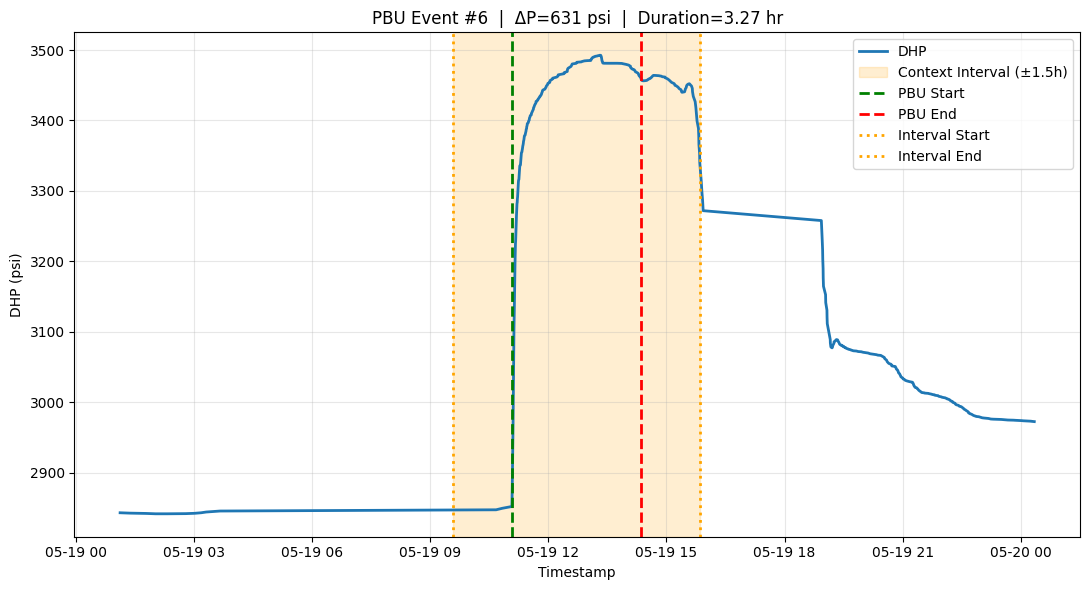

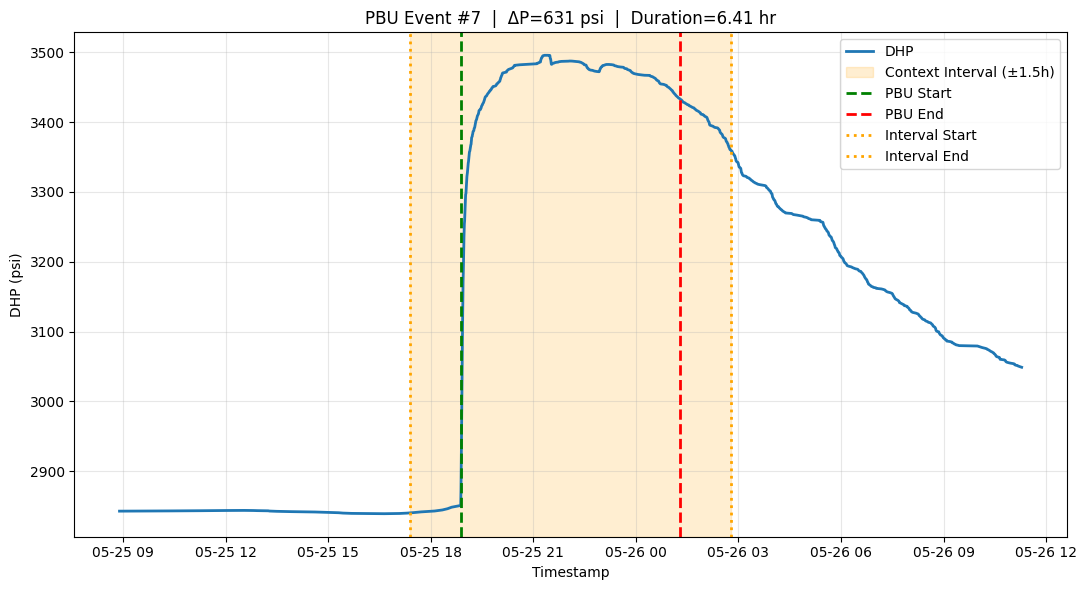

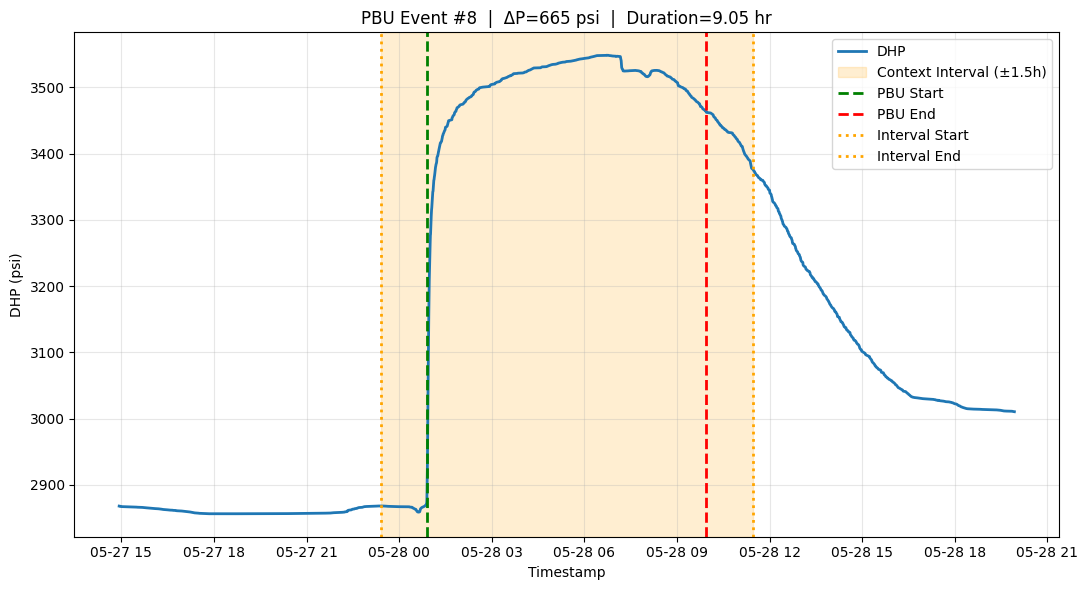

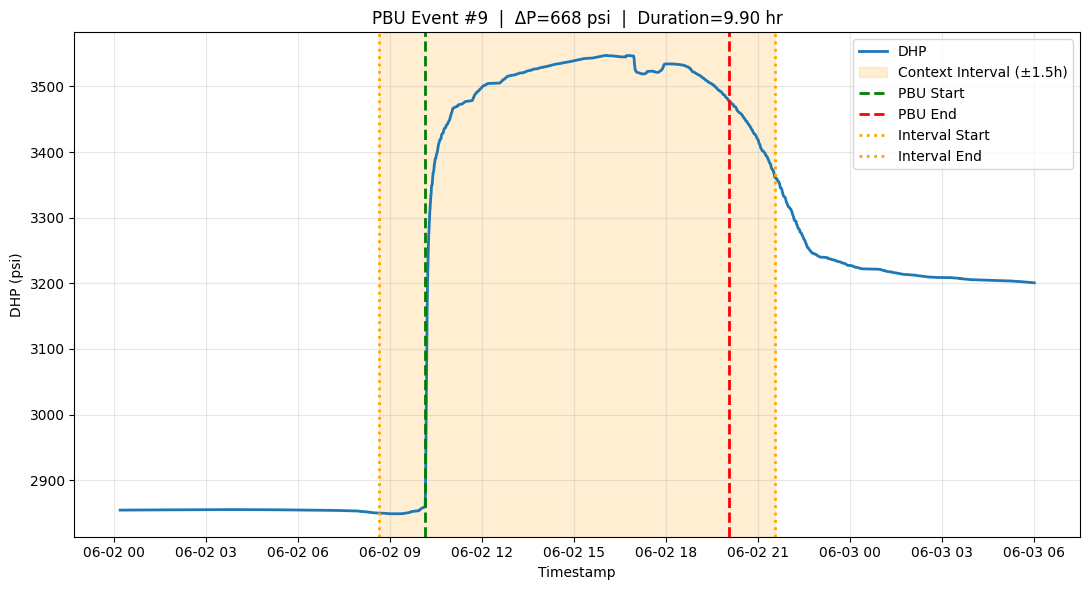

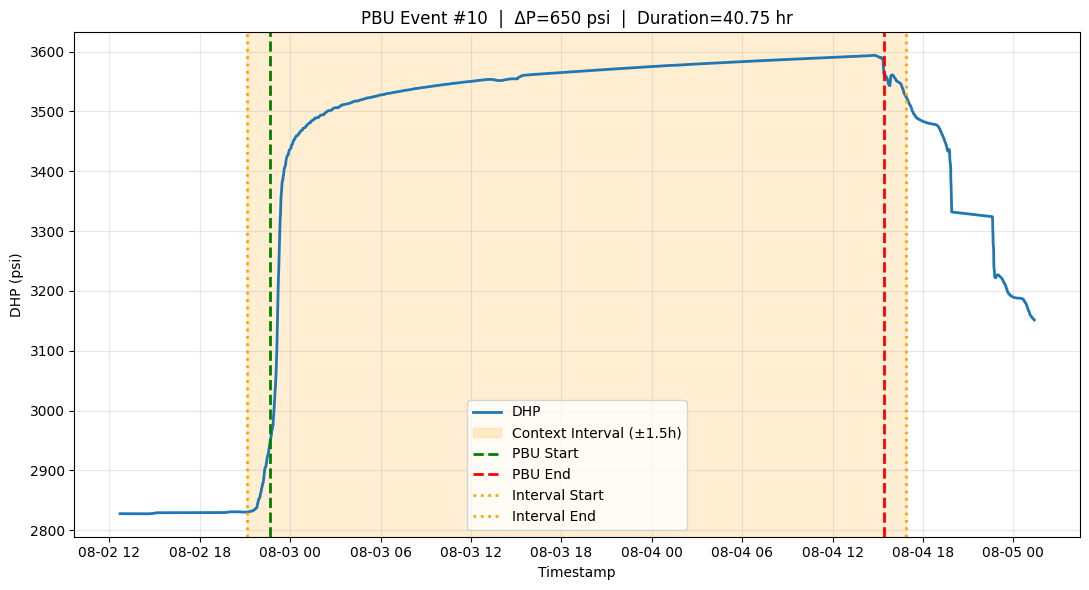

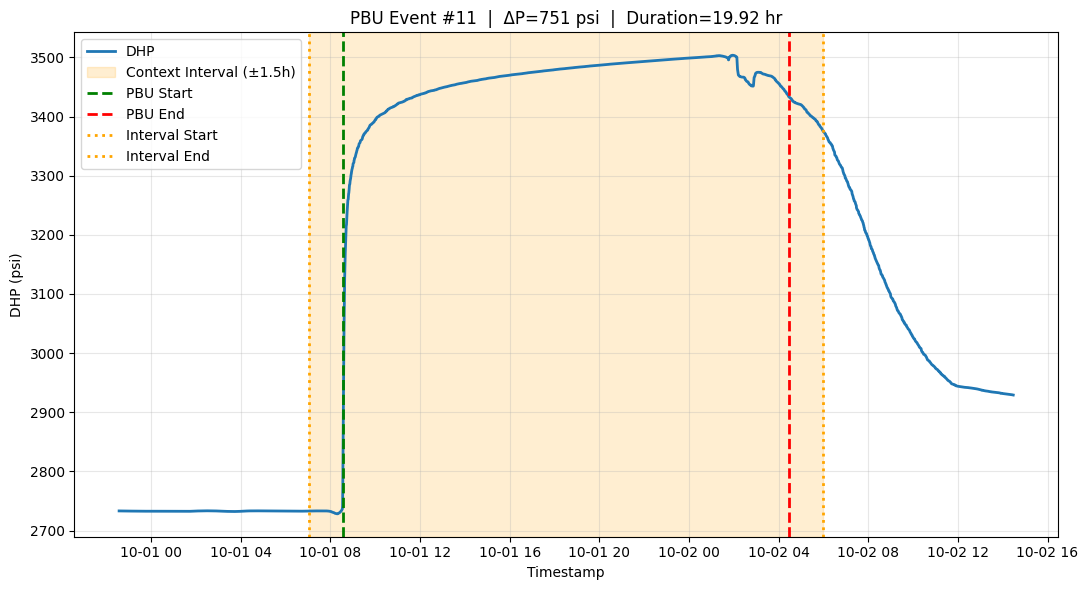

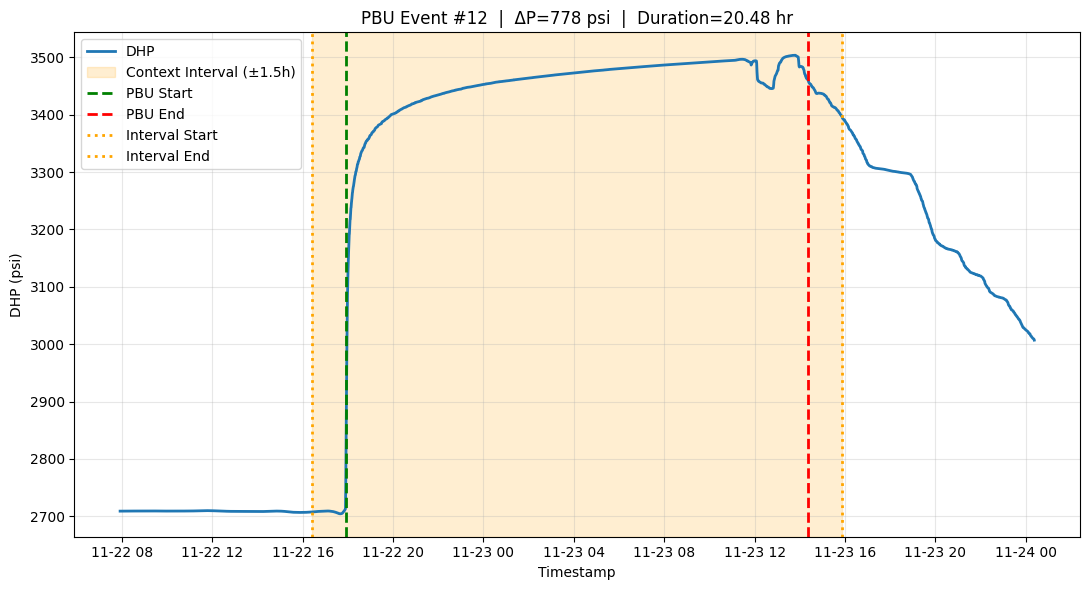

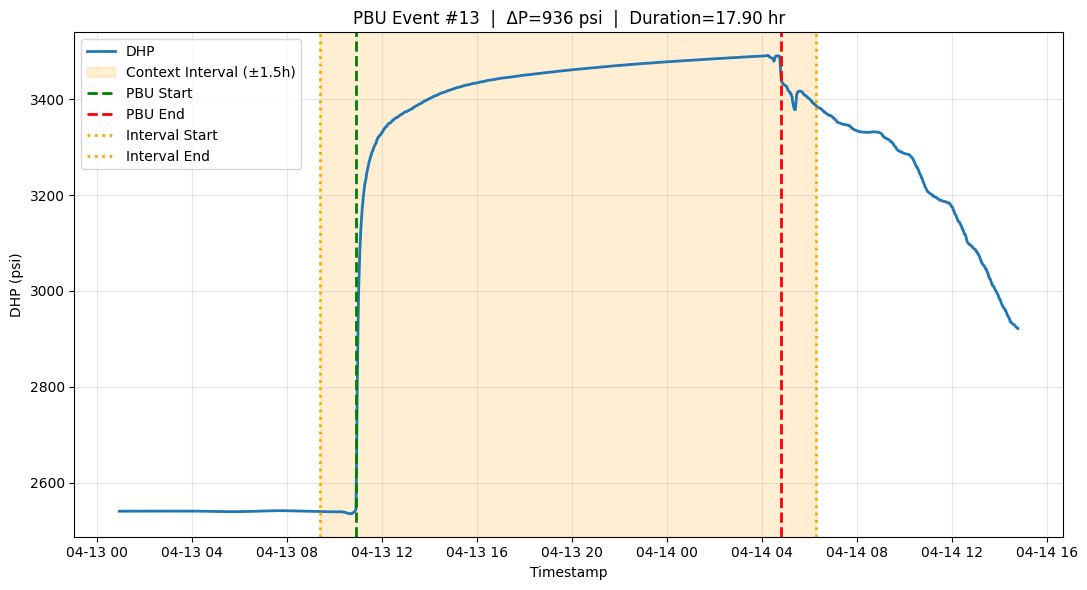

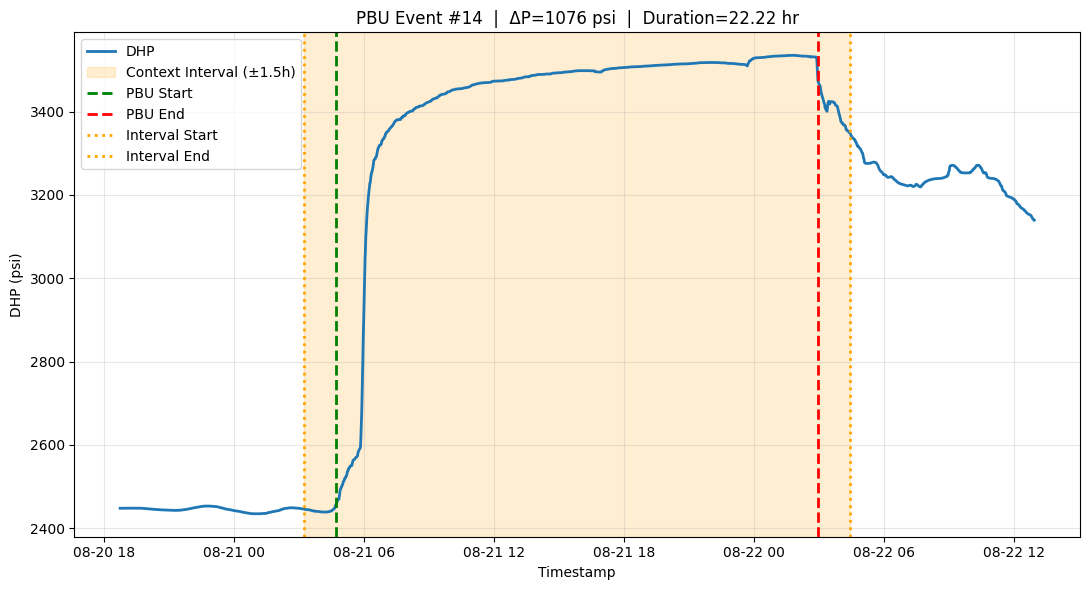

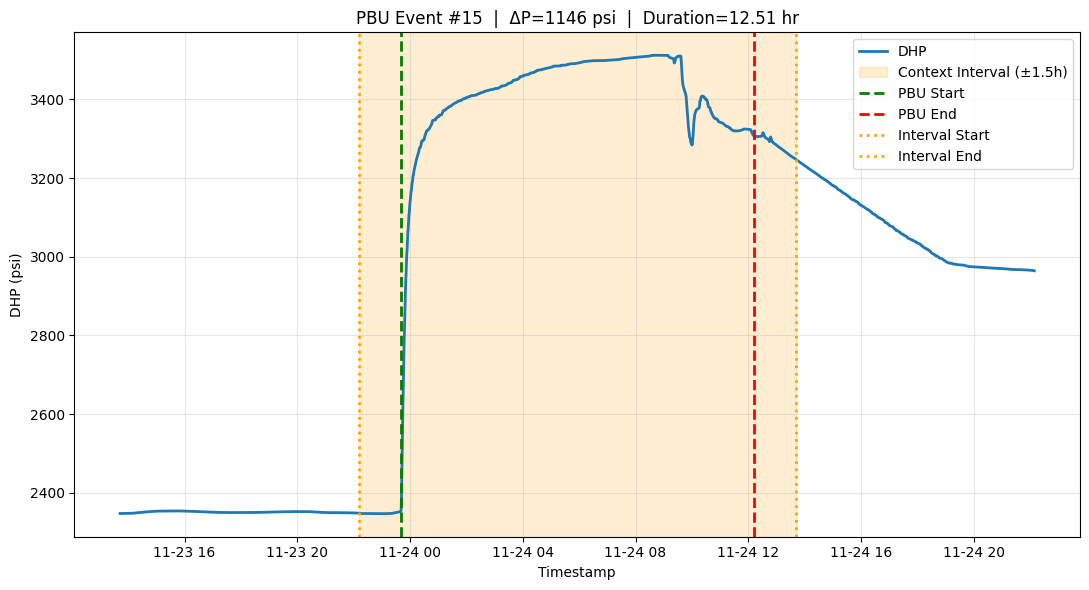

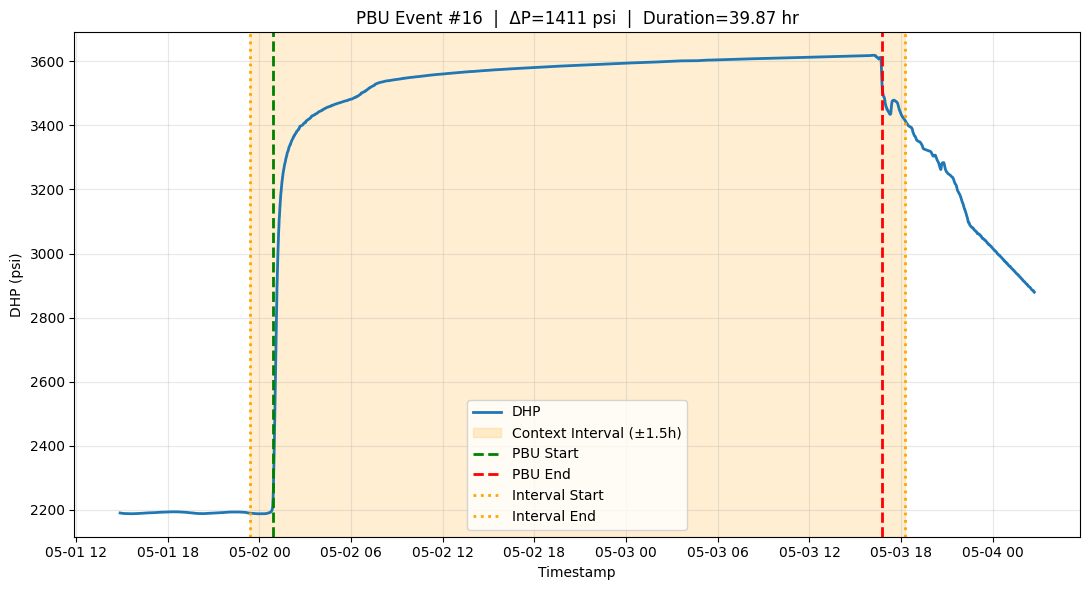

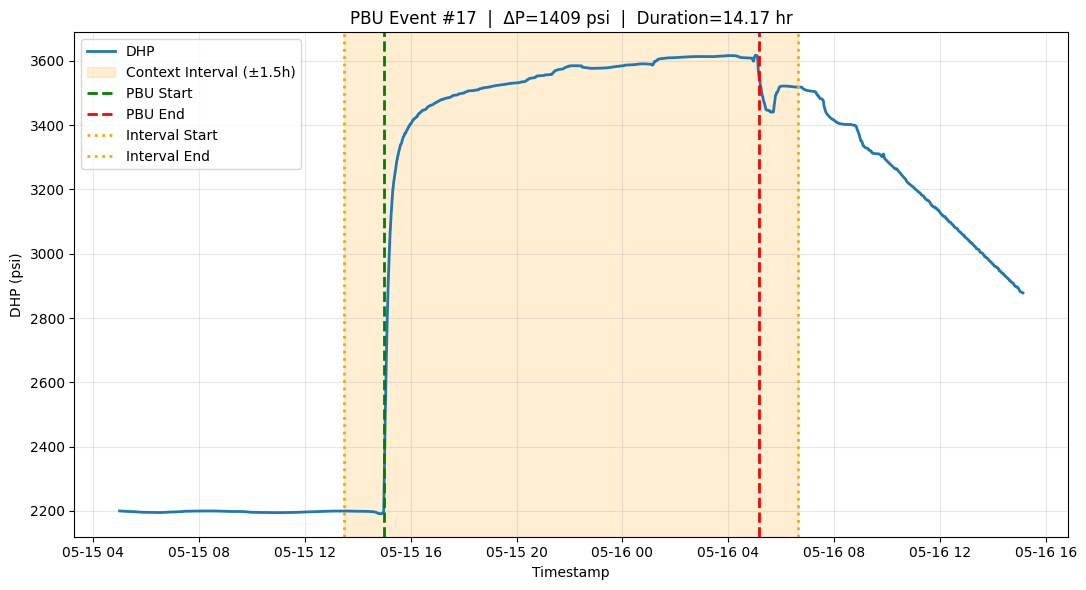

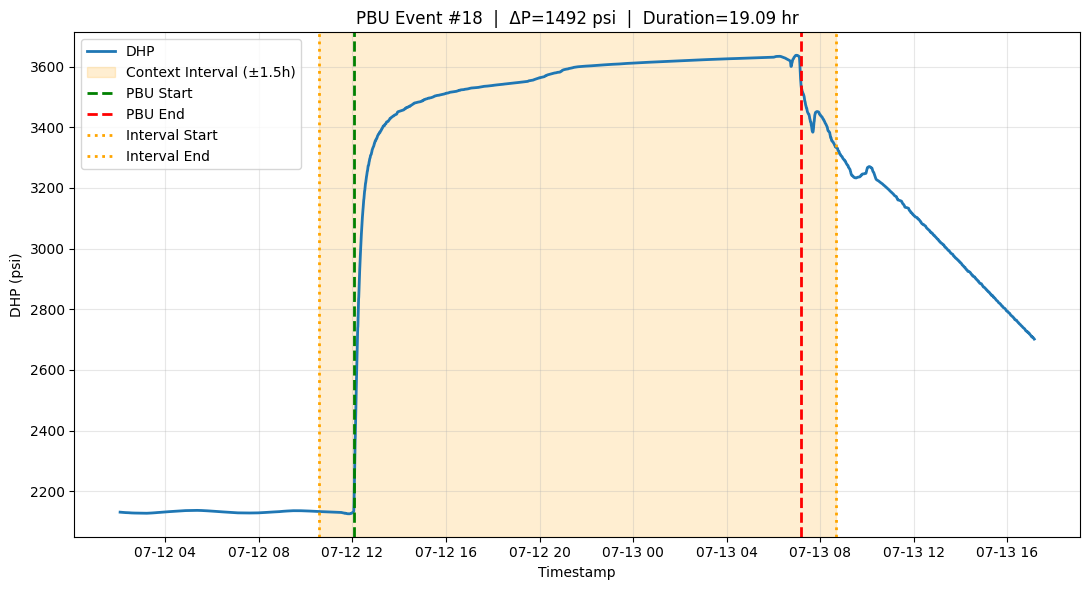

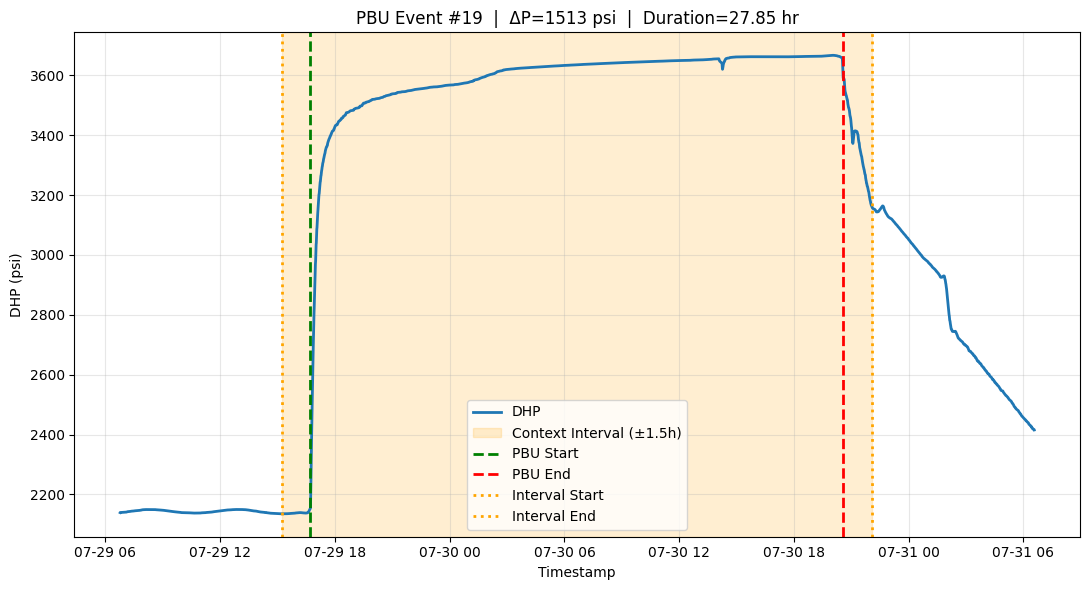

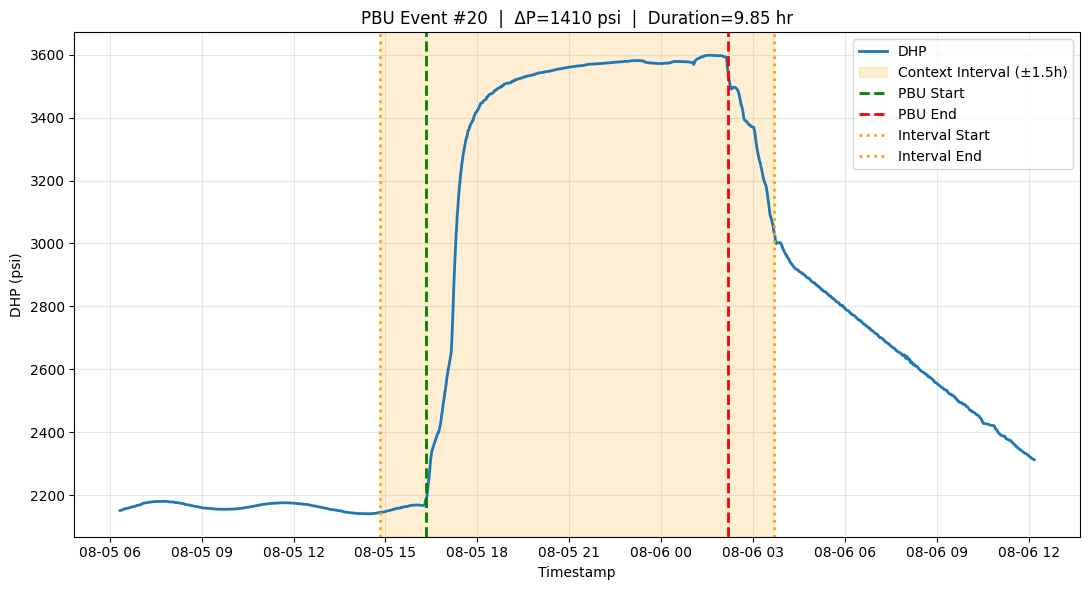

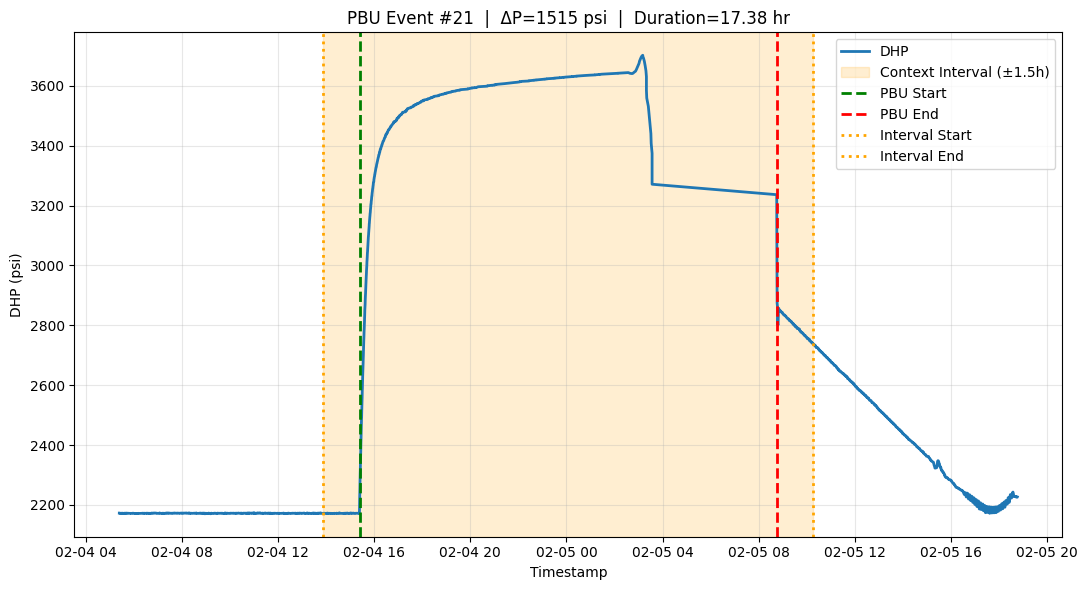

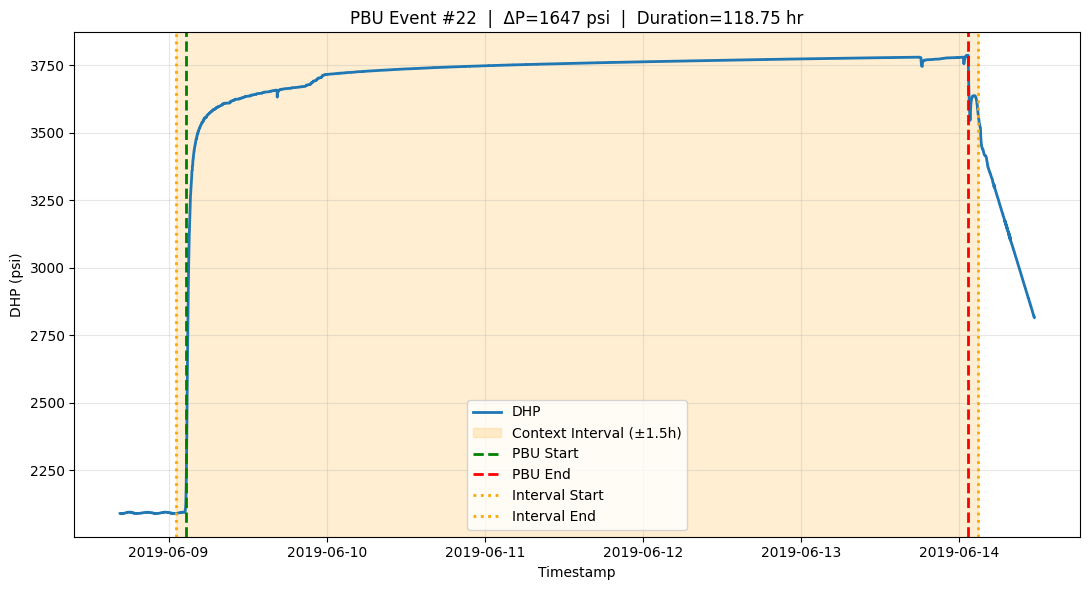

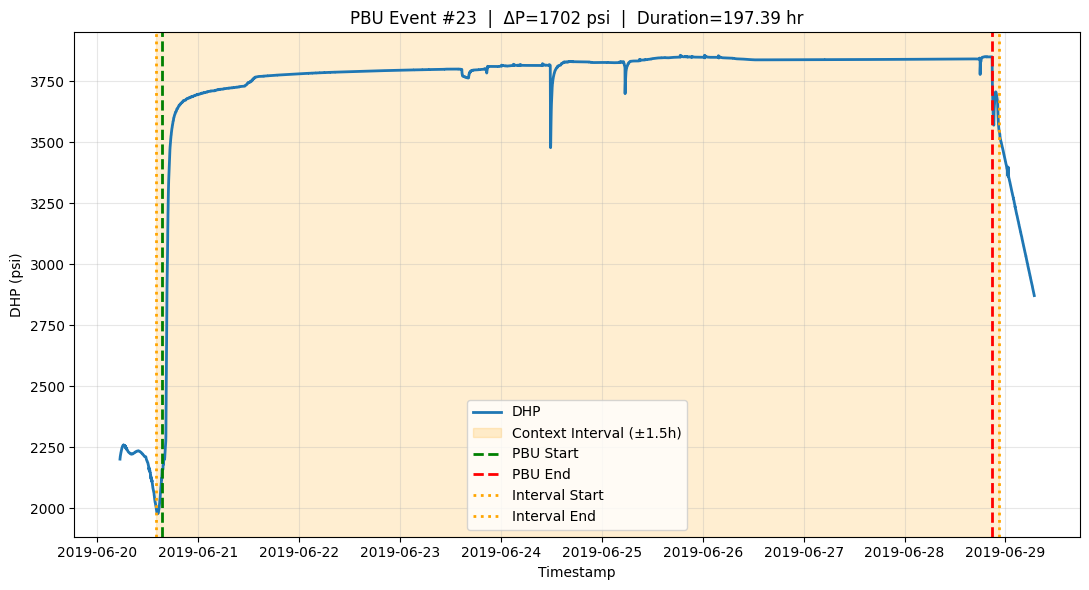

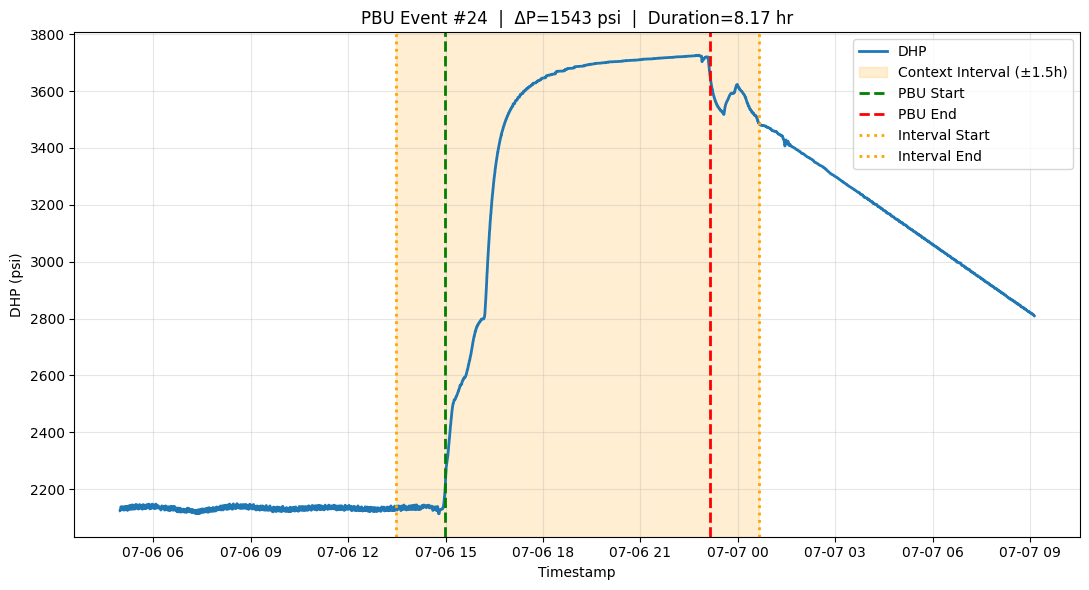

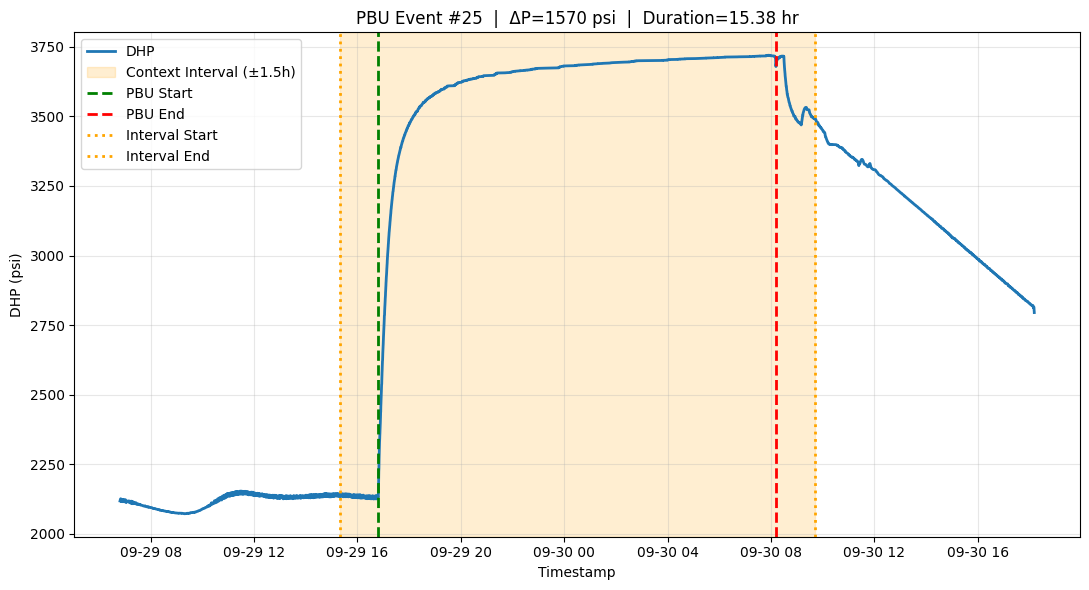

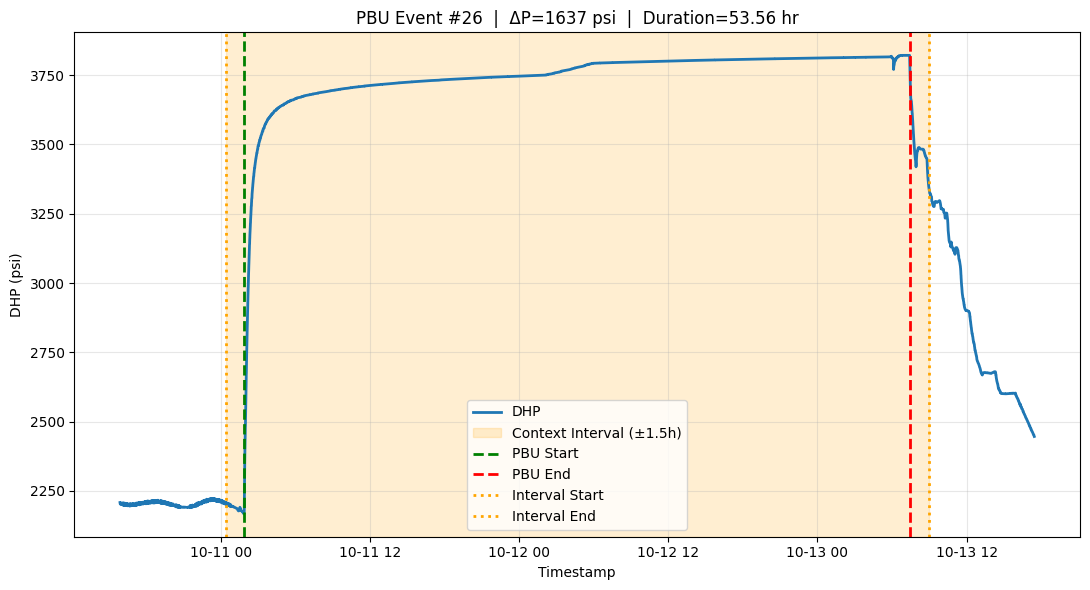

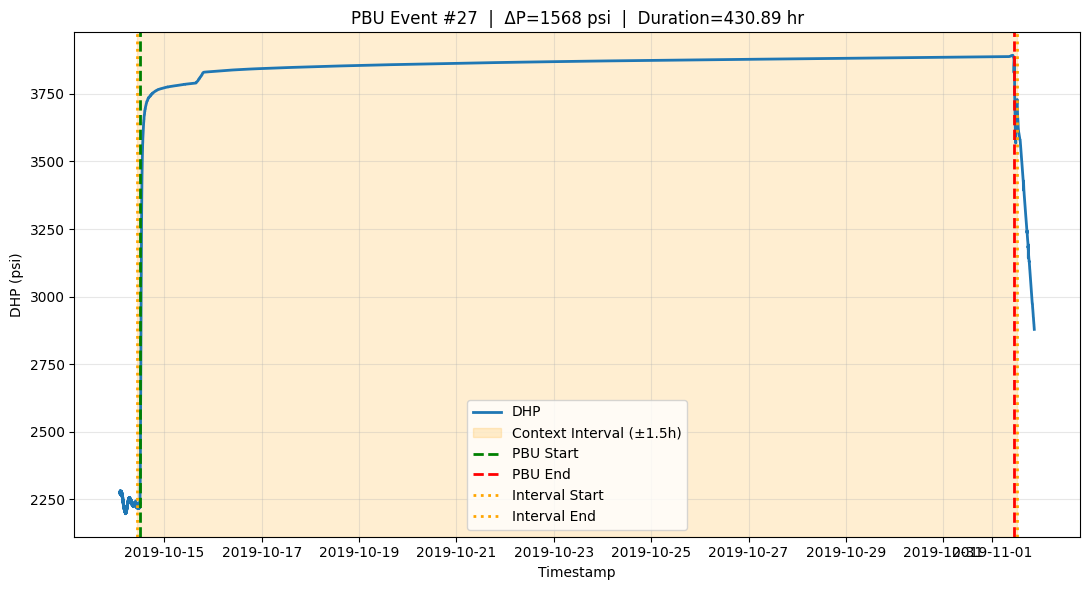

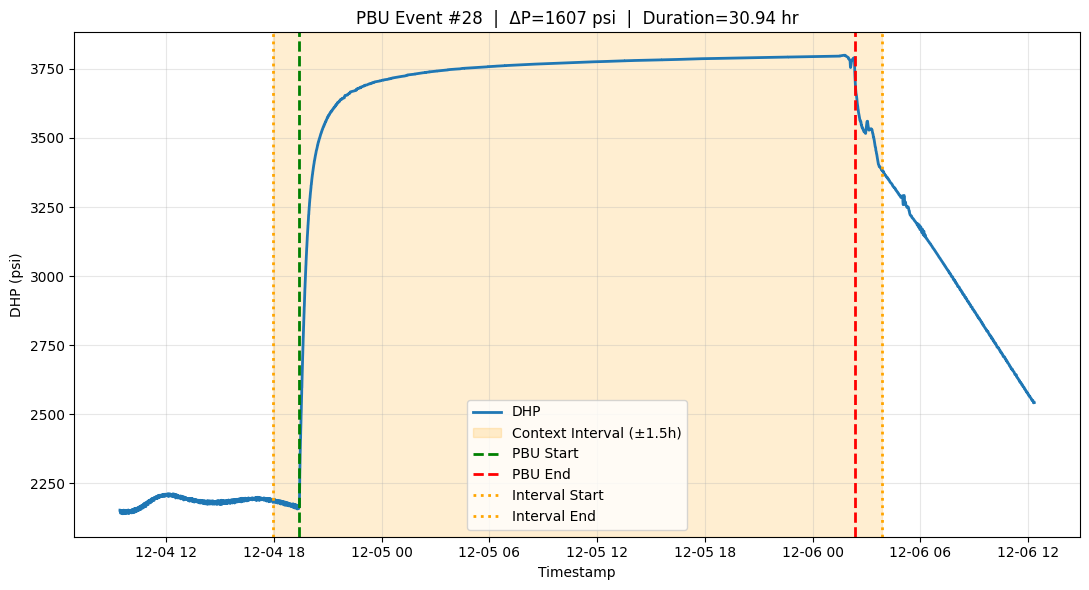

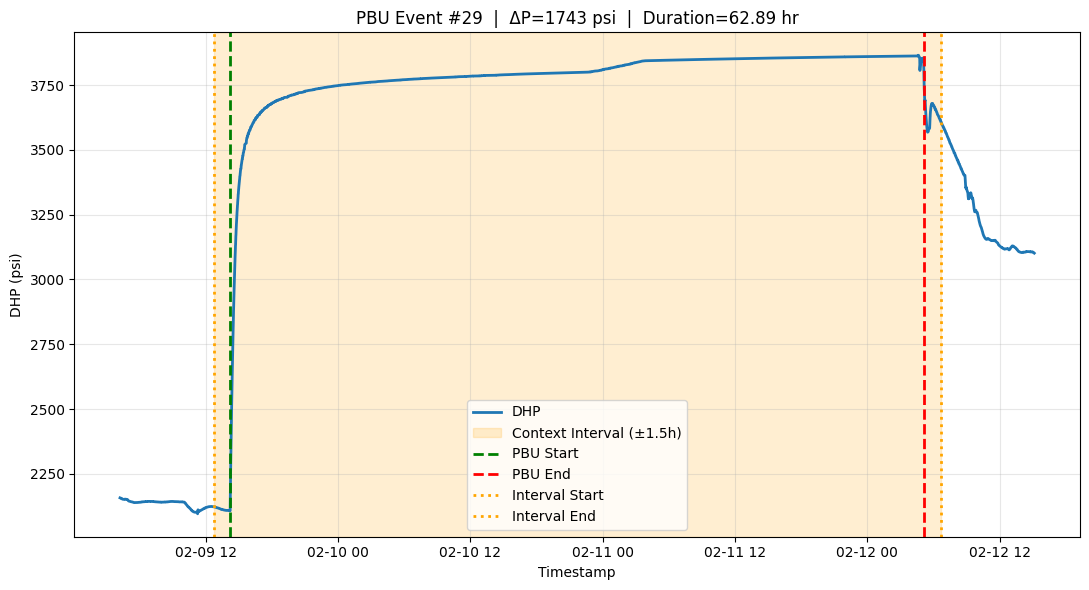

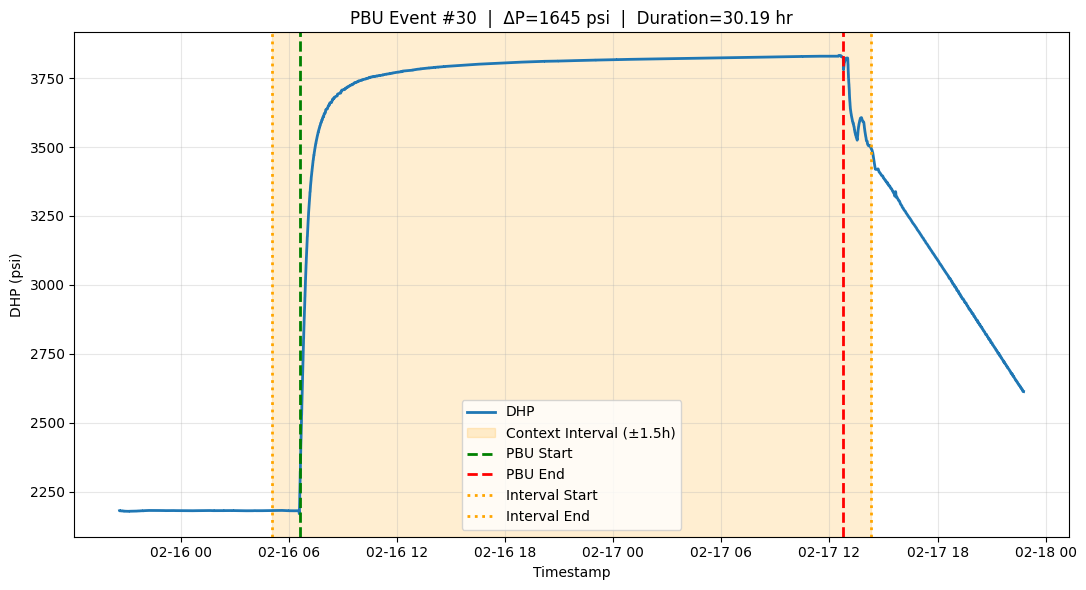

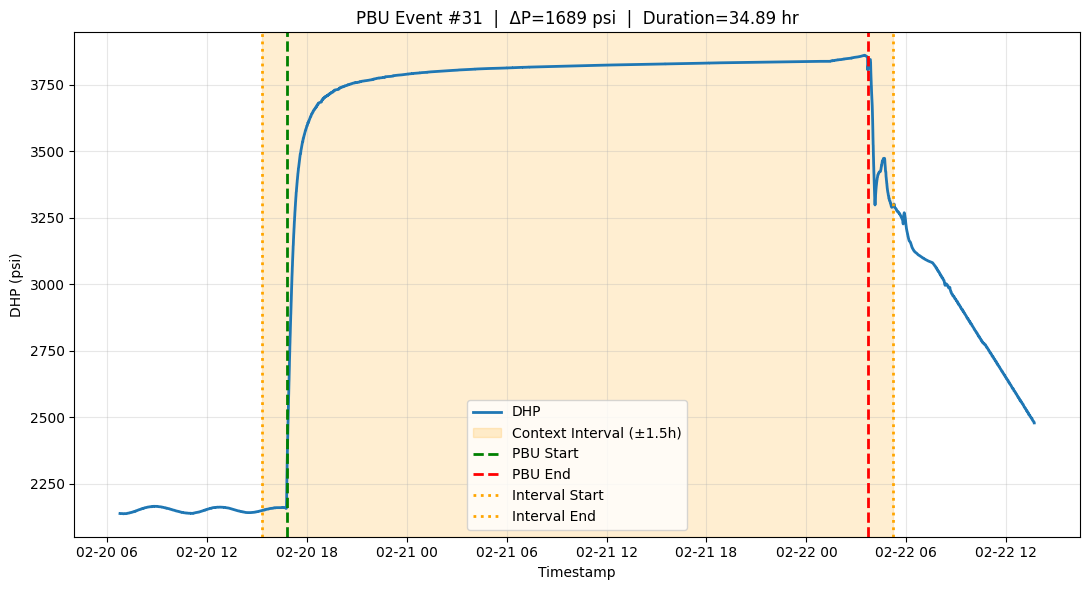

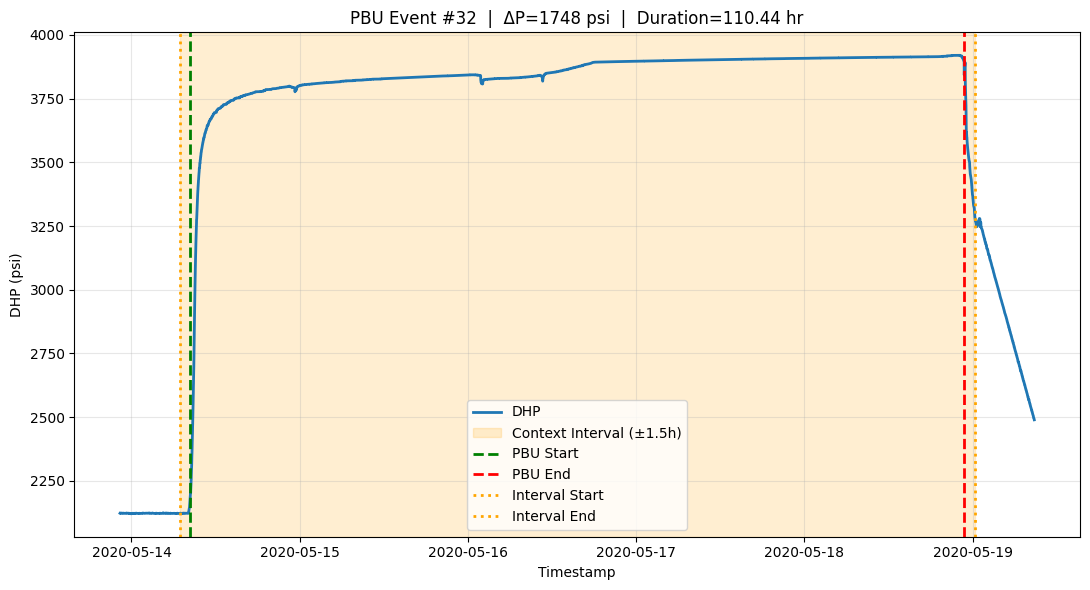

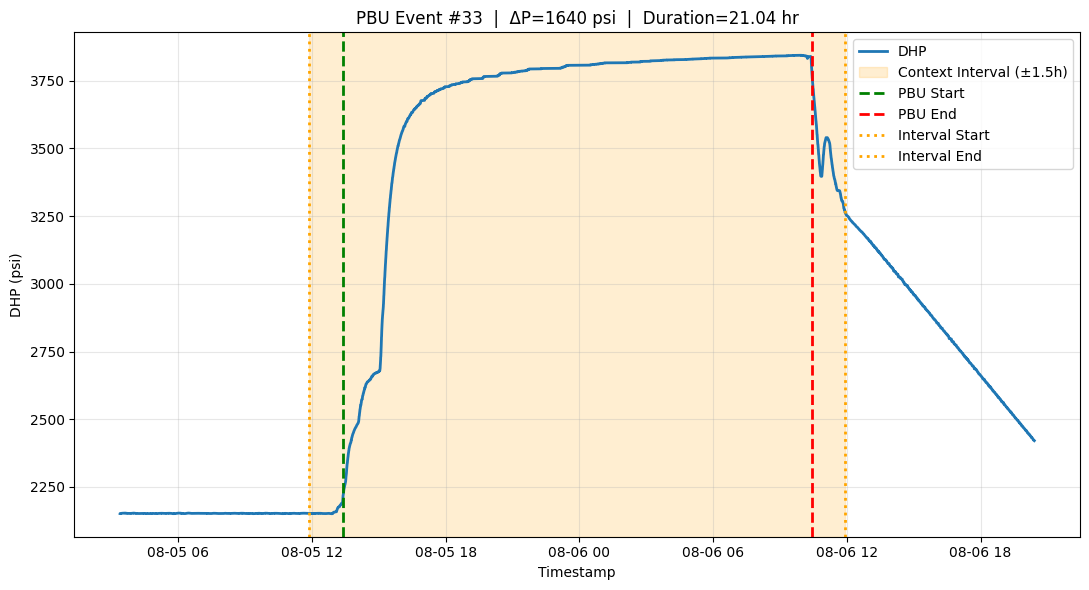

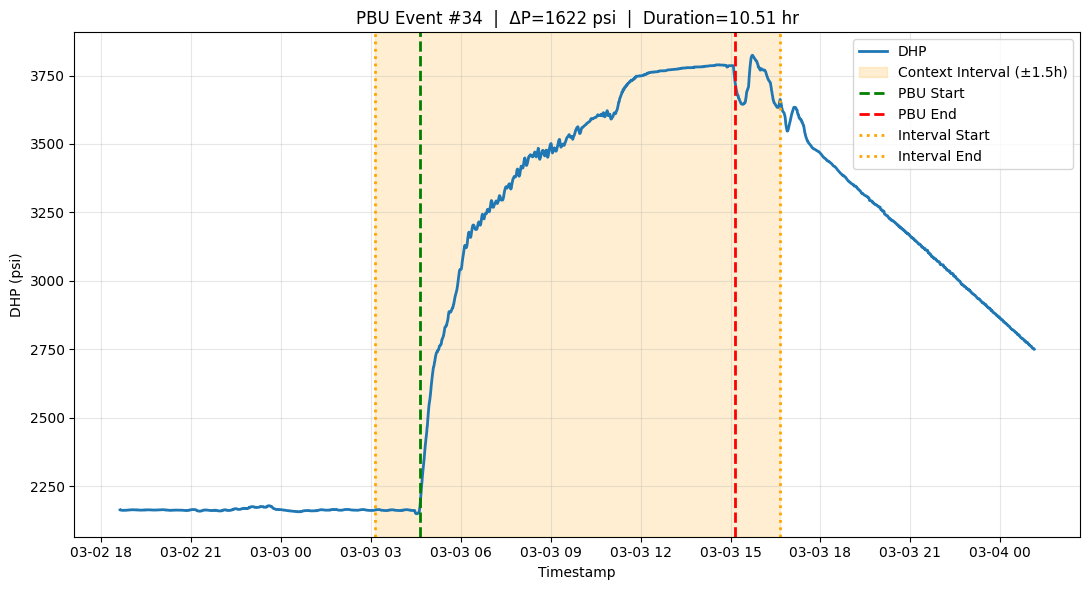

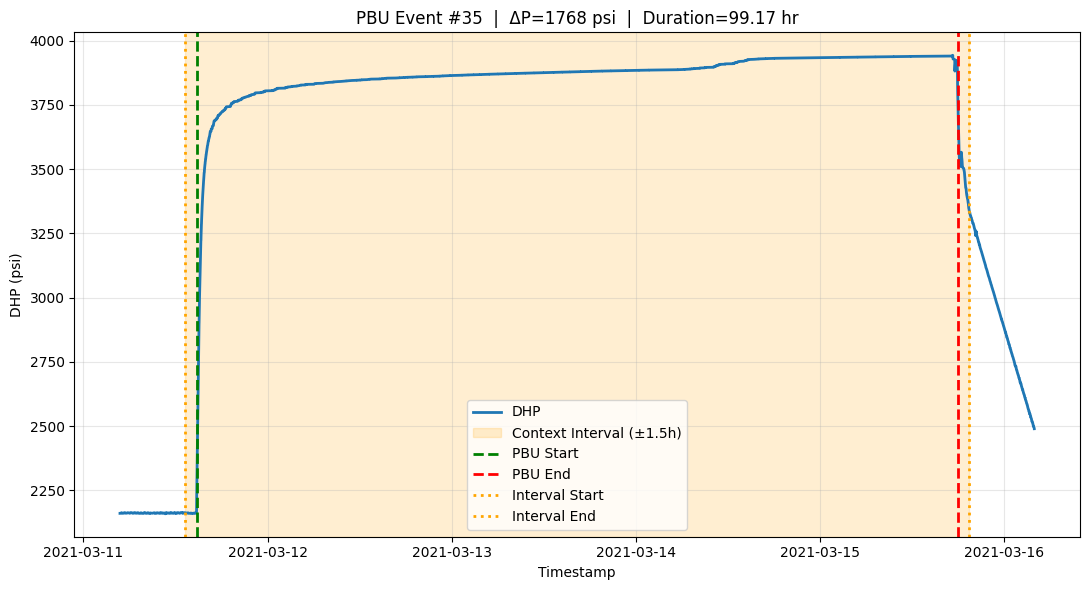

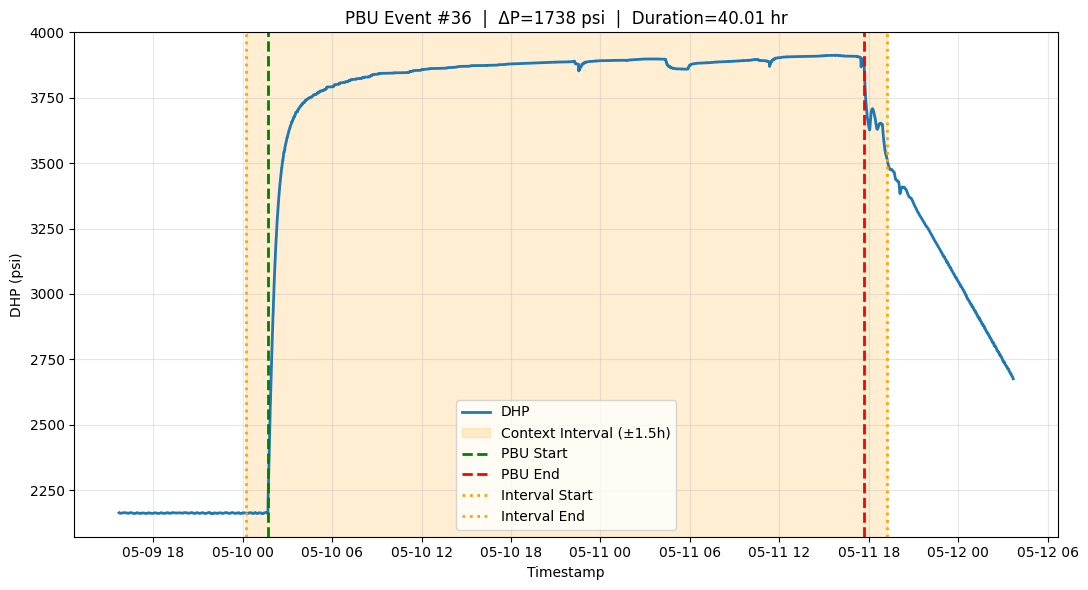

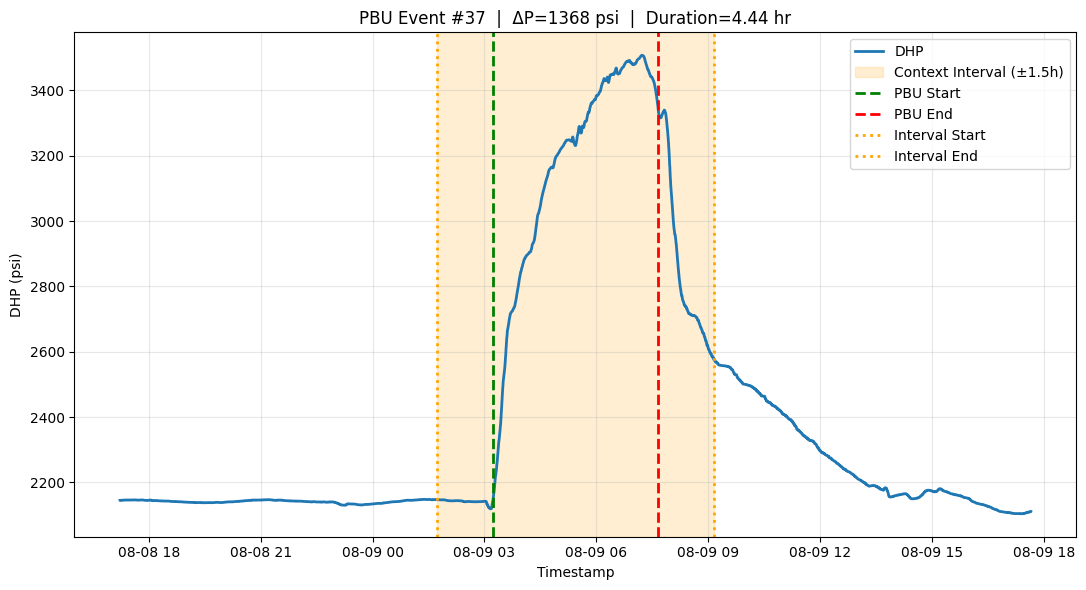

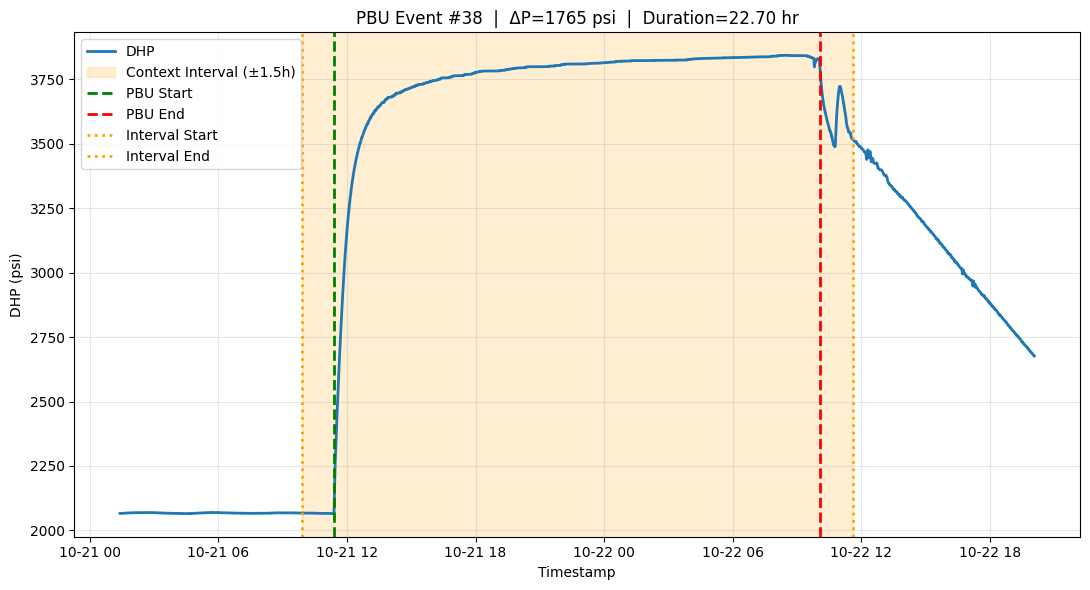

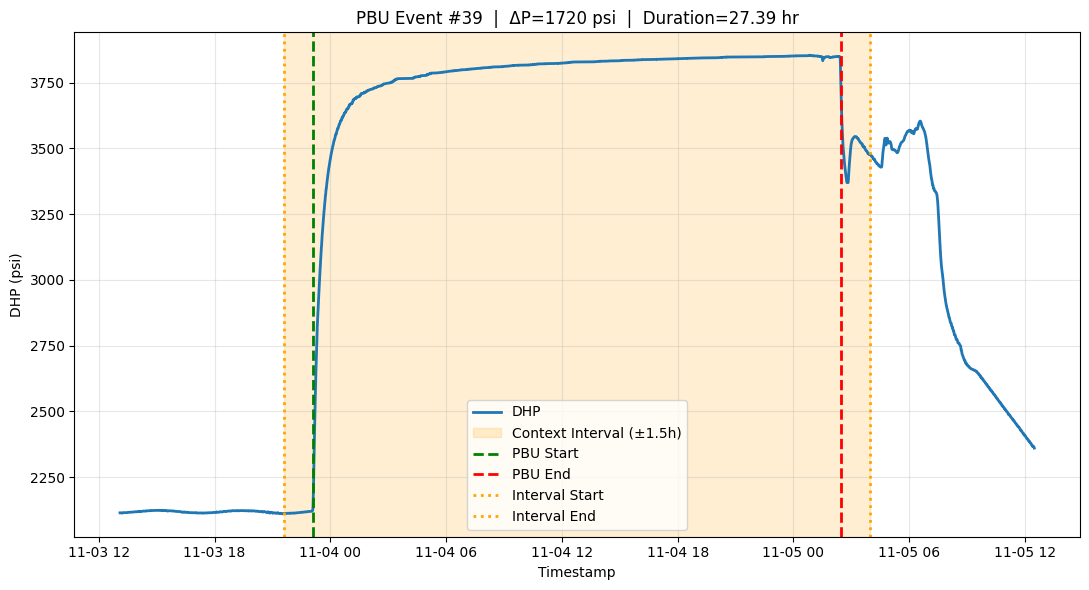

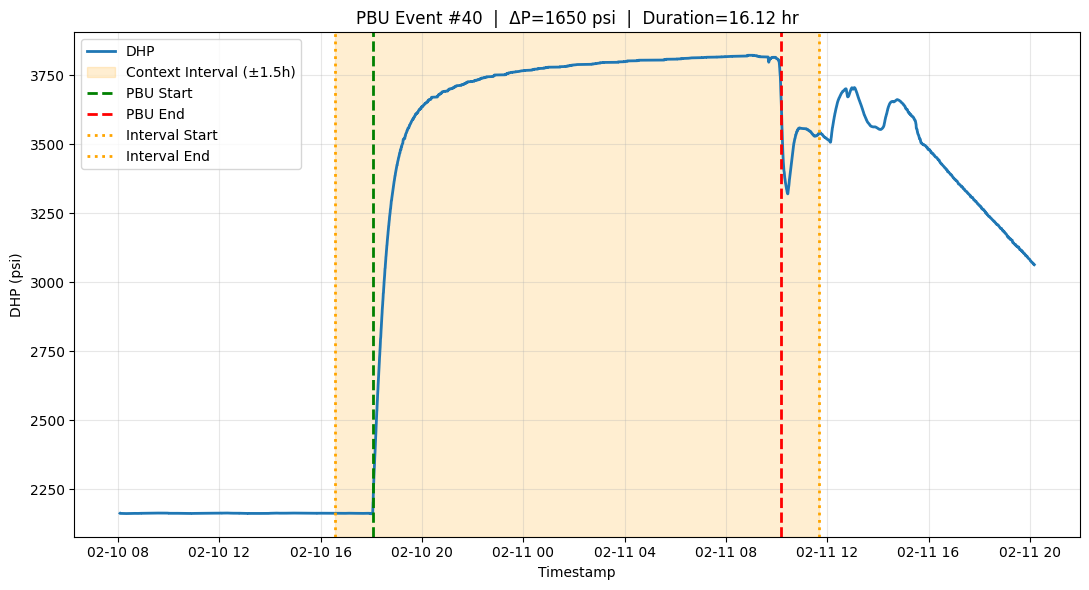

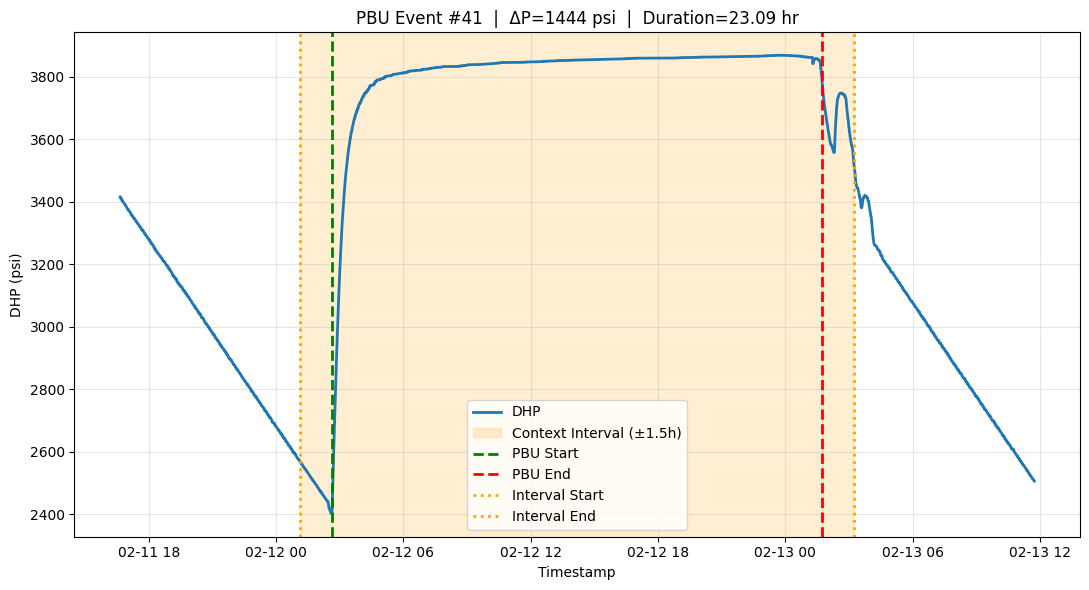

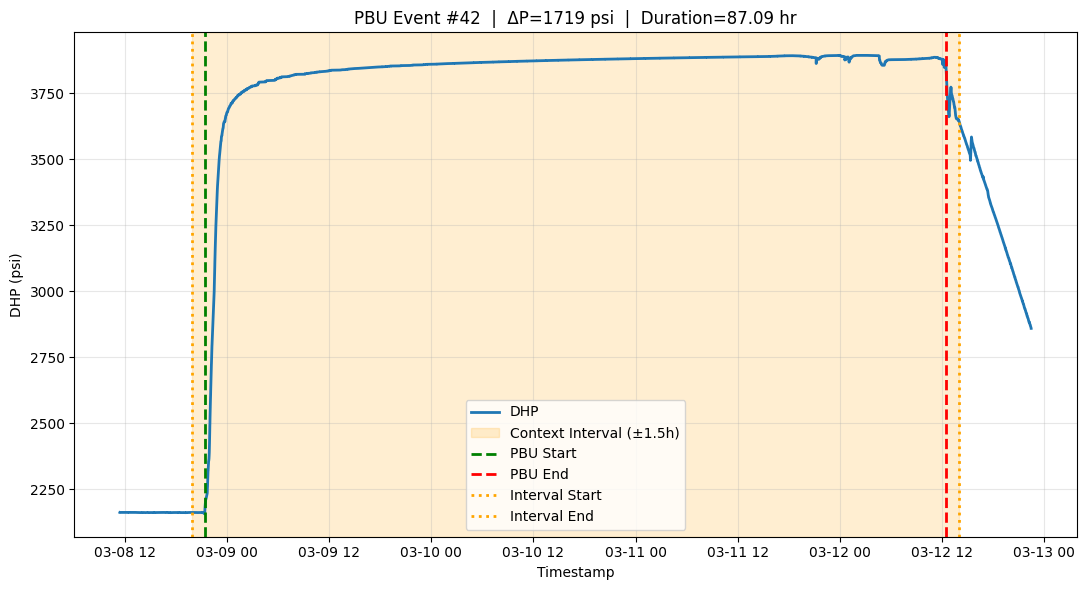

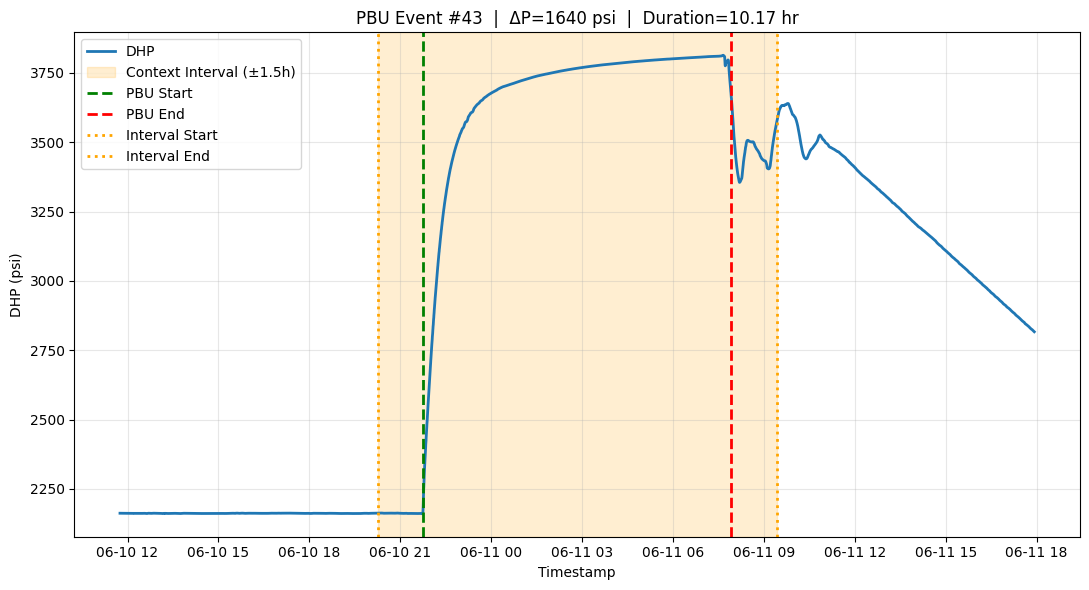

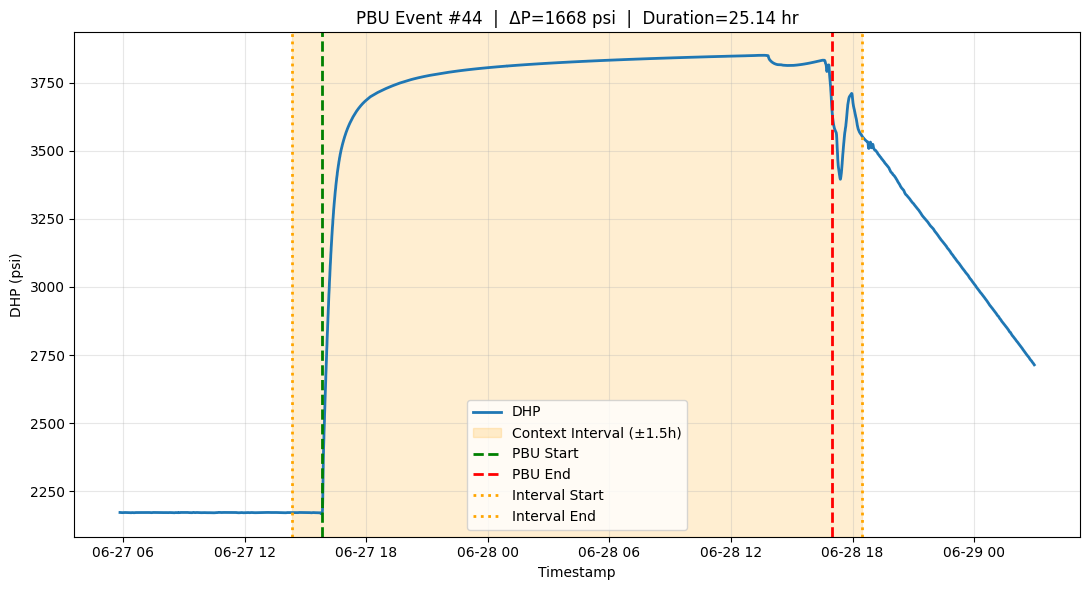

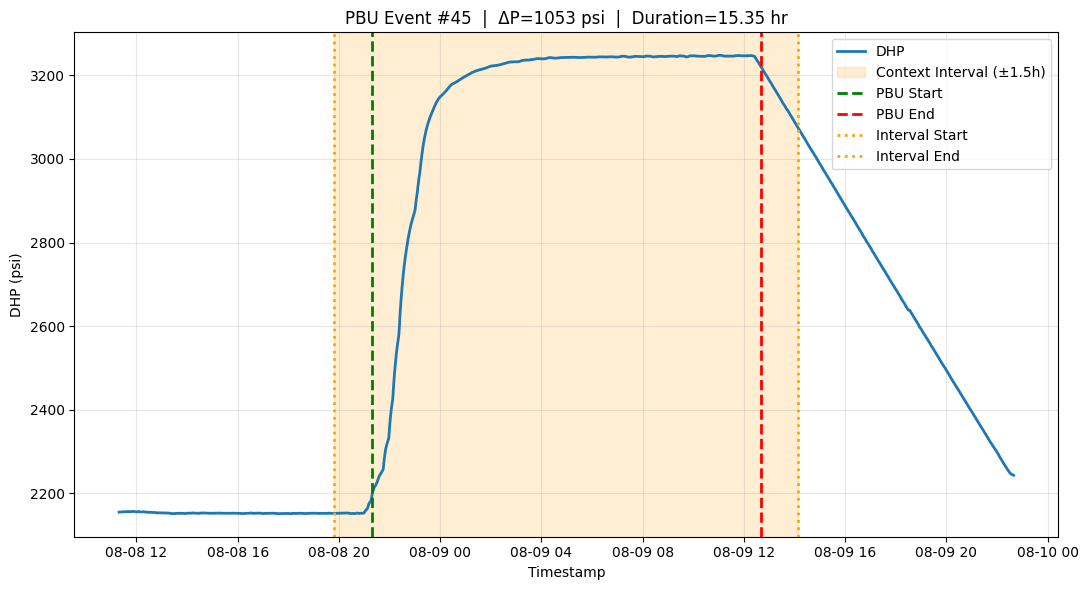

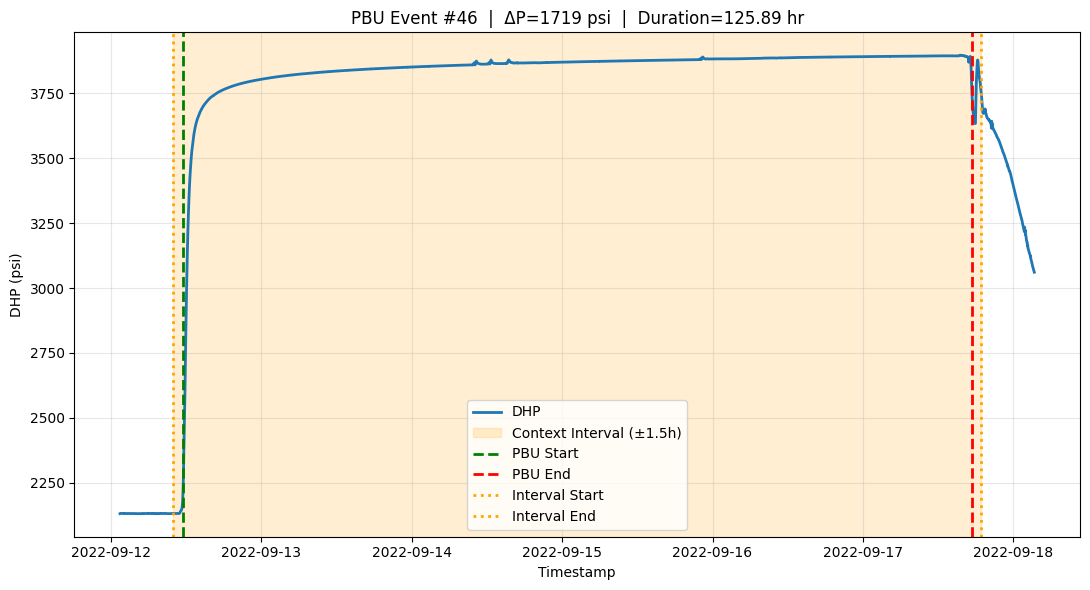

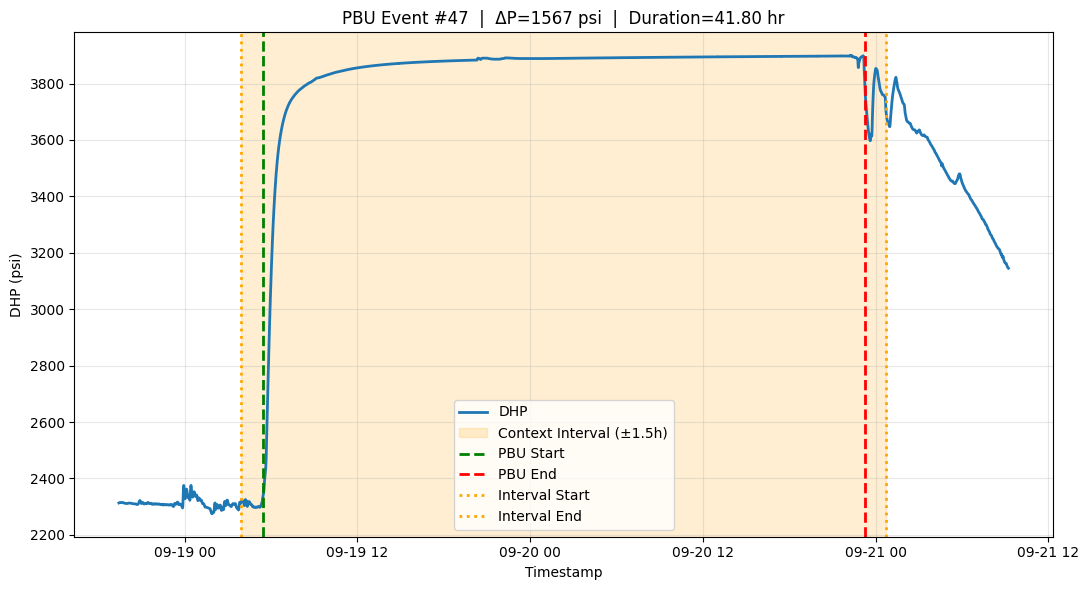

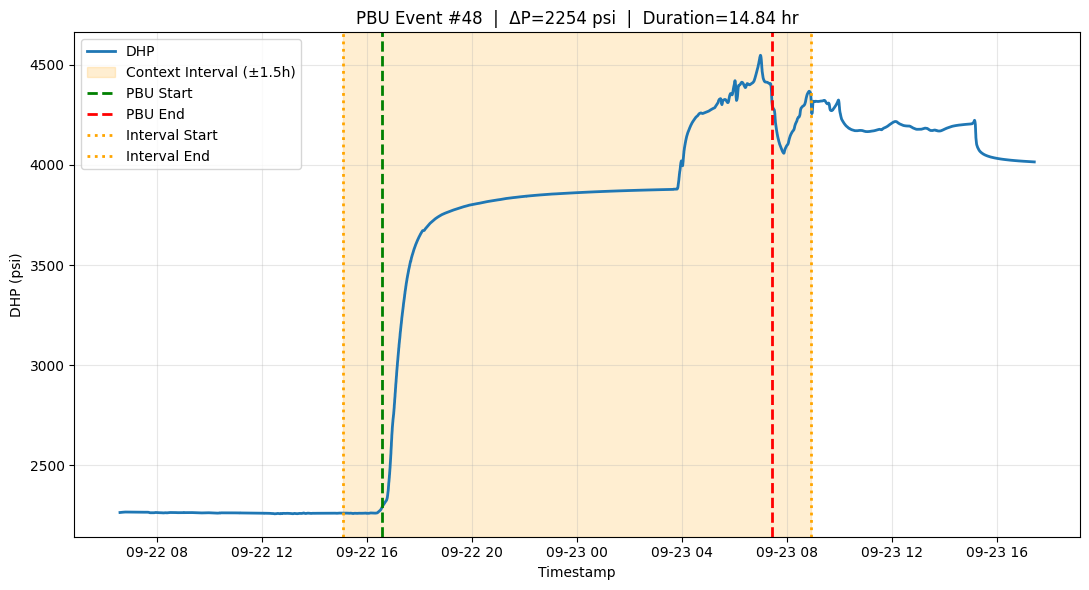

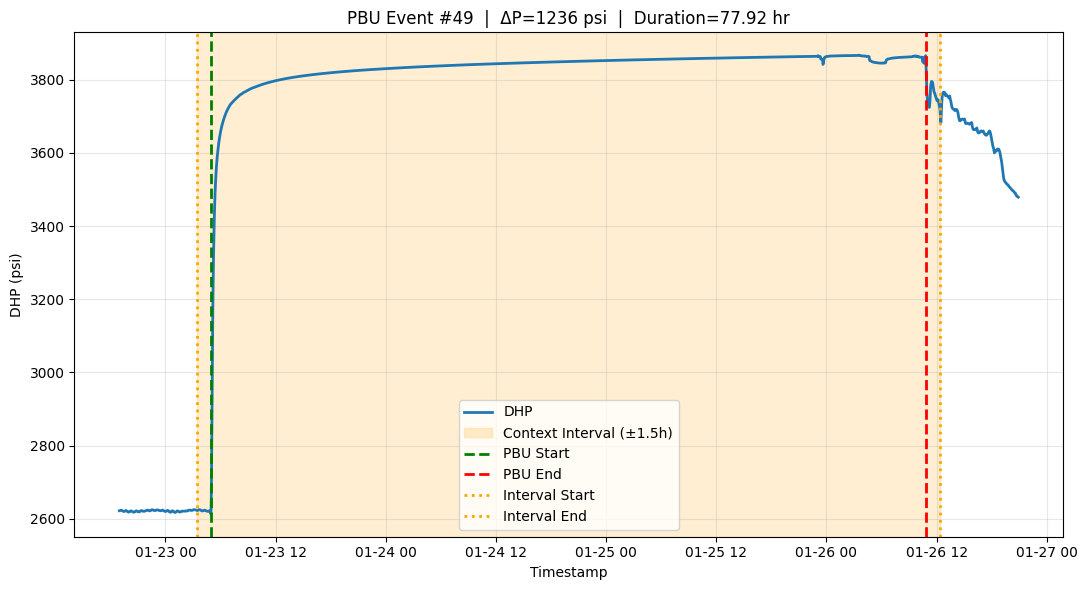

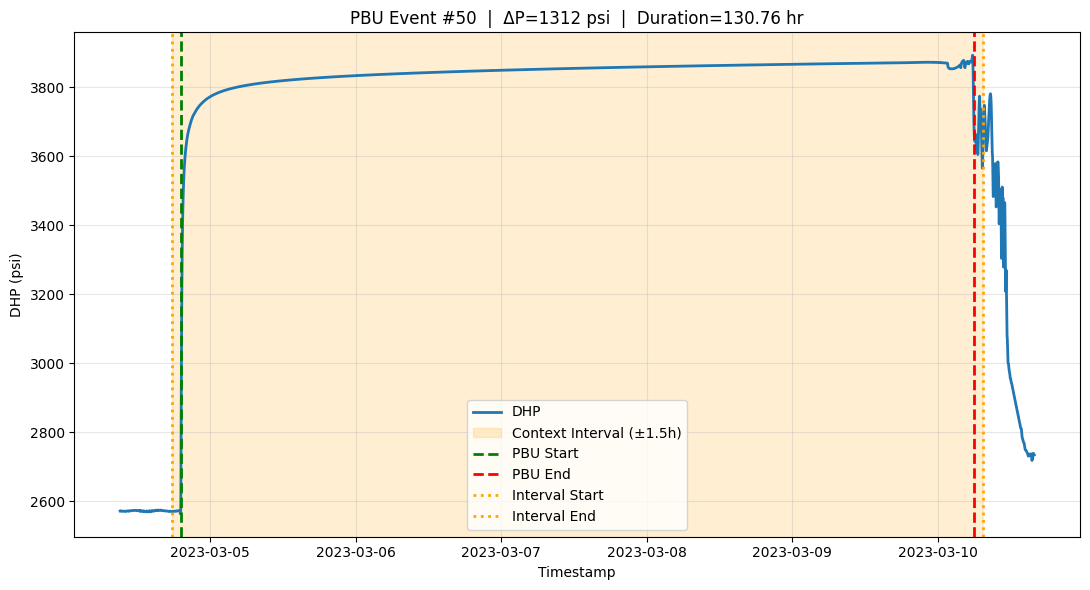

In [74]:
MARGIN_HOURS = 10

for i, event in events_df.head(50).iterrows():

    pbu_start = pd.to_datetime(event["pbu_start"], utc=True)
    pbu_end   = pd.to_datetime(event["pbu_end"],   utc=True)

    interval_start = pd.to_datetime(event["interval_start"], utc=True)
    interval_end   = pd.to_datetime(event["interval_end"],   utc=True)

    mask = (
        (df["timestamp"] >= pbu_start - pd.Timedelta(hours=MARGIN_HOURS)) &
        (df["timestamp"] <= pbu_end   + pd.Timedelta(hours=MARGIN_HOURS))
    )

    df_event = df.loc[mask]

    if df_event.empty:
        continue

    plt.figure(figsize=(11, 6))

    # Pressure curve

    plt.plot(
        df_event["timestamp"],
        df_event["dhp"],
        label="DHP",
        linewidth=2
    )

    # Context interval shading
    plt.axvspan(
        interval_start,
        interval_end,
        alpha=0.18,
        color="orange",
        label="Context Interval (±1.5h)"
    )

    # Event boundaries
    plt.axvline(pbu_start, color="green", linestyle="--", linewidth=2,
                label="PBU Start")

    plt.axvline(pbu_end,   color="red", linestyle="--", linewidth=2,
                label="PBU End")

    # Context markers
    plt.axvline(interval_start, color="orange", linestyle=":",
                linewidth=2, label="Interval Start")

    plt.axvline(interval_end,   color="orange", linestyle=":",
                linewidth=2, label="Interval End")

    plt.xlabel("Timestamp")
    plt.ylabel("DHP (psi)")

    plt.title(
        f"PBU Event #{i+1}  |  ΔP={event['delta_p_psi']:.0f} psi  |  "
        f"Duration={event['duration_hr']:.2f} hr"
    )

    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


SECTION 2

In [75]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from tqdm import tqdm

def normalize_ts(s):
    return (
        pd.to_datetime(s, utc=True)
          .dt.tz_convert(None)
    )

events_df["pbu_start"] = normalize_ts(events_df["pbu_start"])
events_df["pbu_end"]   = normalize_ts(events_df["pbu_end"])
df["timestamp"]        = normalize_ts(df["timestamp"])

# LOAD RESERVOIR PRESSURE REFERENCE TABLE

REF_PATH = "./well_03_Pressure_data.xlsx"

ref_df = pd.read_excel(REF_PATH)

pres_col = "Estimated Reservoir Pressure, psi"

ref_df = (
    ref_df[[pres_col]]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

def stats(series):
    med = np.median(series)
    mad = np.median(np.abs(series - med)) + 1e-6
    return med, mad

P_ref, P_scale = stats(ref_df[pres_col])

print("Reservoir-pressure prior loaded:")
print(f"  P_ref   = {P_ref:.2f} psi")
print(f"  spread  = {P_scale:.2f} psi\n")


# HARD PRESSURE CLAMP

def clip_psi(x, limit=5000.0):
    return np.clip(x, -limit, limit)


def deltaP_radial(dt, m, tp):
    dt = np.maximum(dt, 1e-6)
    tp = max(tp, 1e-6)
    return clip_psi(-m * np.log(tp / dt + 1.0 + 1e-9))


def deltaP_linear(dt, m, tp):
    dt = np.maximum(dt, 1e-6)
    tp = max(tp, 1e-6)
    return clip_psi(m * (np.sqrt(tp) + np.sqrt(dt) - np.sqrt(tp + dt)))

def evaluate_components(dt, mode, P_r, m, A1, k1, A2, k2, tp):

    dt = np.maximum(dt, 1e-6)

    reservoir = clip_psi(np.full_like(dt, P_r))

    if mode == "radial":
        radial = deltaP_radial(dt, m, tp)
        linear = np.zeros_like(dt)

    elif mode == "linear":
        radial = np.zeros_like(dt)
        linear = deltaP_linear(dt, m, tp)

    else:
        radial = np.zeros_like(dt)
        linear = np.zeros_like(dt)

    exp1 = clip_psi(A1*np.exp(-k1*dt))
    exp2 = clip_psi(A2*np.exp(-k2*dt))

    total = clip_psi(reservoir + radial + linear + exp1 + exp2)

    return dict(
        reservoir=reservoir,
        radial=radial,
        linear=linear,
        exp1=exp1,
        exp2=exp2,
        total=total
    )

# FITTER WITH RESERVOIR PRESSURE PRIOR

def fit_reservoir_model(dt, P, tp, max_iter=15000):

    dt = np.maximum(dt, 1e-6)

    dt_last = dt[-1]
    sqrt_tp = np.sqrt(tp)
    sqrt_dt = np.sqrt(dt)
    sqrt_tp_dt = np.sqrt(tp + dt)

    # amplitudes must satisfy |A| >= 10
    def amp_from_free(B):
        return np.sign(B) * (10.0 + np.abs(B))

    # starting guess biased toward reference reservoir pressure
    guess = (
        max(np.max(P), P_ref),   # P_r
        20,                      # m
        5, 0.05,
        5, 0.05
    )

    lower_bounds = (
        1000.0,
        10.0,      # m ≥ 10
        -1e9, 0.01,
        -1e9, 0.01
    )

    upper_bounds = (
        1e9,
        5000.0,
        1e9, 10.0,
        1e9, 10.0
    )

    TAIL_LIMIT = 50.0
    tail_w = 50.0

    # soft prior nudging P_r toward historical range
    prior_w = 2.0


    # COMPONENTS CALCULATION
    def fast_components(mode, P_r, m, A1, k1, A2, k2):

        if mode == "radial":
            radial = -m * np.log(tp / dt + 1.0)
            linear = 0.0

        else:
            radial = 0.0
            linear = m * (sqrt_tp + sqrt_dt - sqrt_tp_dt)

        exp1 = A1 * np.exp(-k1 * dt)
        exp2 = A2 * np.exp(-k2 * dt)

        total = P_r + radial + linear + exp1 + exp2
        return total, exp1, exp2


    # RESIDUALS
    def make_residual_fun(mode):

        def residuals(theta):

            P_r, m, B1, k1, B2, k2 = theta

            A1 = amp_from_free(B1)
            A2 = amp_from_free(B2)

            total, _, _ = fast_components(mode, P_r, m, A1, k1, A2, k2)

            res = P - total

            # force exponentials to convergeto 0)
            tail1 = A1 * np.exp(-k1 * dt_last)
            tail2 = A2 * np.exp(-k2 * dt_last)

            tail_pen = (
                max(0.0, abs(tail1) - TAIL_LIMIT) +
                max(0.0, abs(tail2) - TAIL_LIMIT)
            )

            # P_r toward historical range
            P_prior = (P_r - P_ref) / P_scale

            return np.hstack((res, tail_w * tail_pen, prior_w * P_prior))

        return residuals


    # RADIAL FIT
    params_r = None
    rmse_r = np.inf

    try:
        sol_r = least_squares(
            make_residual_fun("radial"),
            guess,
            bounds=(lower_bounds, upper_bounds),
            max_nfev=max_iter
        )

        P_r, m, B1, k1, B2, k2 = sol_r.x
        A1 = amp_from_free(B1)
        A2 = amp_from_free(B2)

        total_r, _, _ = fast_components("radial", P_r, m, A1, k1, A2, k2)
        rmse_r = np.sqrt(np.mean((P - total_r)**2))

        params_r = (P_r, m, A1, k1, A2, k2)

    except Exception:
        pass


    # LINEAR FIT
    params_l = None
    rmse_l = np.inf

    try:
        sol_l = least_squares(
            make_residual_fun("linear"),
            guess,
            bounds=(lower_bounds, upper_bounds),
            max_nfev=max_iter
        )

        P_r, m, B1, k1, B2, k2 = sol_l.x
        A1 = amp_from_free(B1)
        A2 = amp_from_free(B2)

        total_l, _, _ = fast_components("linear", P_r, m, A1, k1, A2, k2)
        rmse_l = np.sqrt(np.mean((P - total_l)**2))

        params_l = (P_r, m, A1, k1, A2, k2)

    except Exception:
        pass


    # MODEL SELECTION
    if params_r is None and params_l is not None:
        mode, params, rmse = "linear", params_l, rmse_l

    elif params_l is None and params_r is not None:
        mode, params, rmse = "radial", params_r, rmse_r

    elif params_l is None and params_r is None:
        P_const = max(np.median(P), 1000.0)

        comps = dict(
            reservoir=np.full_like(dt, P_const),
            radial=np.zeros_like(dt),
            linear=np.zeros_like(dt),
            exp1=np.zeros_like(dt),
            exp2=np.zeros_like(dt),
            total=np.full_like(dt, P_const),
        )

        return dict(
            mode="none",
            params=None,
            rmse=np.inf,
            P_res=P_const,
            components=comps,
            tp=tp
        )

    else:
        if rmse_l + 1 < rmse_r:
            mode, params, rmse = "linear", params_l, rmse_l
        else:
            mode, params, rmse = "radial", params_r, rmse_r

    comps = evaluate_components(dt, mode, *params, tp)

    return dict(
        mode=mode,
        params=params,
        rmse=rmse,
        P_res=params[0],
        components=comps,
        tp=tp
    )

results = []

print(f"\nProcessing {len(events_df)} PBU events...\n")

for i, (_, ev) in enumerate(tqdm(events_df.iterrows(), total=len(events_df))):

    mask = (df.timestamp >= ev.pbu_start) & (df.timestamp <= ev.pbu_end)
    seg = df.loc[mask].copy()

    if len(seg) < 20:
        continue

    dt = (seg.timestamp - seg.timestamp.iloc[0]).dt.total_seconds() / 3600
    P = seg.dhp.values

    tp0 = 24  # fixed at 24 due to limited data

    fit = fit_reservoir_model(dt.values, P, tp0)

    results.append({
        **ev,
        "dt": dt.values,
        "P": P,
        "tp_hr": tp0,
        "P_res": fit["P_res"],
        "rmse": fit["rmse"],
        "mode": fit["mode"],
        "params": fit["params"],
        "components": fit["components"]
    })


reservoir_df = pd.DataFrame(results)

print("\nEvents processed:", len(reservoir_df))
print(reservoir_df[["pbu_start","tp_hr","P_res","rmse","mode"]])


Reservoir-pressure prior loaded:
  P_ref   = 3970.00 psi
  spread  = 63.00 psi


Processing 56 PBU events...



100%|██████████| 56/56 [00:46<00:00,  1.20it/s]


Events processed: 56
                 pbu_start  tp_hr        P_res        rmse    mode
0  2015-02-18 12:46:56.935     24  4612.426321  173.223708  radial
1  2015-02-26 22:13:42.721     24  3940.147597   27.162255  radial
2  2015-11-04 16:56:11.900     24  3714.183466   15.752581  radial
3  2016-04-21 20:30:56.300     24  3537.440551   44.040767  radial
4  2016-05-14 08:56:46.200     24  3307.773570   21.191785  radial
5  2016-05-19 11:04:39.400     24  3763.055942   56.521397  radial
6  2016-05-25 18:52:50.500     24  3457.483390   26.346968  linear
7  2016-05-28 00:53:57.700     24  3550.271394   41.715901  radial
8  2016-06-02 10:09:18.900     24  3540.217904   36.902200  radial
9  2016-08-02 22:38:21.800     24  3445.017937   27.536977  linear
10 2016-10-01 08:32:48.200     24  3454.287628   15.119166  linear
11 2016-11-22 17:53:56.600     24  3518.187470   17.594086  radial
12 2017-04-13 10:53:57.700     24  3327.769643    6.315298  linear
13 2017-08-21 04:43:45.600     24  3513.

In [76]:
# extract m from params tuple for each event
reservoir_df["m"] = reservoir_df["params"].apply(lambda p: p[1] if p is not None else np.nan)

print("m statistics\n-------------")
print("count :", reservoir_df["m"].count())
print("mean  :", reservoir_df["m"].mean())
print("std   :", reservoir_df["m"].std())
print("min   :", reservoir_df["m"].min())
print("max   :", reservoir_df["m"].max())


m statistics
-------------
count : 56
mean  : 127.43589692408372
std   : 133.70676400455415
min   : 10.000000000000002
max   : 453.1055779539786



FINAL FITTED MODEL

Selected flow regime: RADIAL

P_model(Δt) = P_r  −  m·ln(tp/Δt + 1)  +  A₁·exp(-k₁Δt)  +  A₂·exp(-k₂Δt)\n
Substituted parameters:
P_r = 3833.993 psi
m   = 243.815
tp  = 24.000 hr
A1  = 10.001,   k1 = 0.194310
A2  = 353.948,   k2 = 0.172982

Compact substituted function:

P(Δt) = 3833.993  −  243.815·ln(24.000/Δt + 1)  +  10.001·exp(-0.194310Δt)  +  353.948·exp(-0.172982Δt)


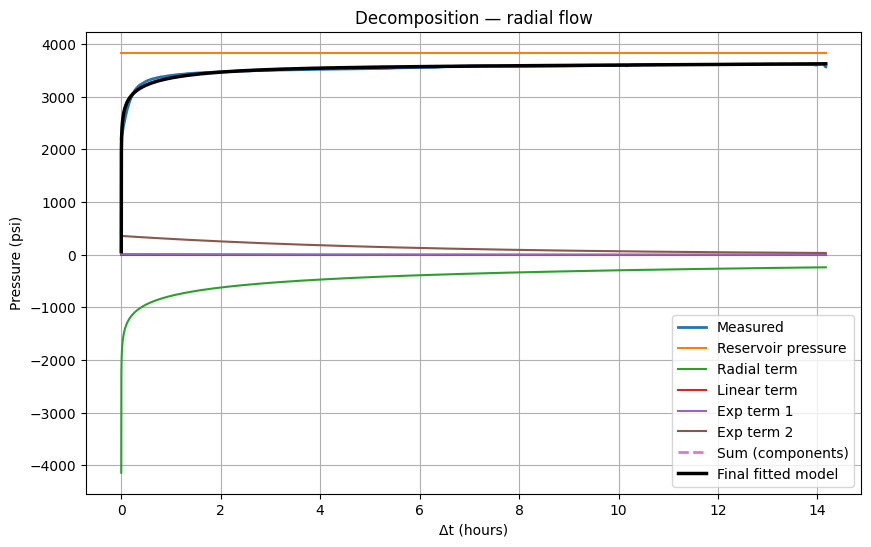

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Choose event by start time
target = pd.Timestamp("2018-05-15 14:58:48.400")

ev = reservoir_df.loc[reservoir_df["pbu_start"] == target]

if ev.empty:
    raise ValueError("Event not found")

ev = ev.iloc[0]

dt = ev["dt"]
P = ev["P"]
comp = ev["components"]

mode = ev["mode"]
tp = ev["tp_hr"]
params = ev["params"]

P_r, m, A1, k1, A2, k2 = params


#  Print final fitted model equation


print("\nFINAL FITTED MODEL\n")

if mode == "radial":
    print("Selected flow regime: RADIAL\n")

    print(r"P_model(Δt) = "
          r"P_r  −  m·ln(tp/Δt + 1)  +  "
          r"A₁·exp(-k₁Δt)  +  A₂·exp(-k₂Δt)\n")

    print("Substituted parameters:")
    print(f"P_r = {P_r:.3f} psi")
    print(f"m   = {m:.3f}")
    print(f"tp  = {tp:.3f} hr")
    print(f"A1  = {A1:.3f},   k1 = {k1:.6f}")
    print(f"A2  = {A2:.3f},   k2 = {k2:.6f}\n")

    def P_model(dt):
        return (
            P_r
            - m * np.log(tp / np.maximum(dt,1e-6) + 1.0)
            + A1*np.exp(-k1*dt)
            + A2*np.exp(-k2*dt)
        )


elif mode == "linear":
    print("Selected flow regime: LINEAR\n")

    print(r"P_model(Δt) = "
          r"P_r  +  m(√tp + √Δt − √(tp+Δt))  +  "
          r"A₁·exp(-k₁Δt)  +  A₂·exp(-k₂Δt)\n")

    print("Substituted parameters:")
    print(f"P_r = {P_r:.3f} psi")
    print(f"m   = {m:.3f}")
    print(f"tp  = {tp:.3f} hr")
    print(f"A1  = {A1:.3f},   k1 = {k1:.6f}")
    print(f"A2  = {A2:.3f},   k2 = {k2:.6f}\n")

    def P_model(dt):
        dtc = np.maximum(dt, 1e-6)
        return (
            P_r
            + m * (np.sqrt(tp) + np.sqrt(dtc) - np.sqrt(tp + dtc))
            + A1*np.exp(-k1*dtc)
            + A2*np.exp(-k2*dtc)
        )


else:
    print("Mode = NONE (fallback constant-pressure model)\n")
    def P_model(dt):
        return np.full_like(dt, P_r)


# Print compact explicit functional form
print("Compact substituted function:\n")

if mode == "radial":
    print(
        f"P(Δt) = {P_r:.3f}"
        f"  −  {m:.3f}·ln({tp:.3f}/Δt + 1)"
        f"  +  {A1:.3f}·exp(-{k1:.6f}Δt)"
        f"  +  {A2:.3f}·exp(-{k2:.6f}Δt)"
    )

elif mode == "linear":
    print(
        f"P(Δt) = {P_r:.3f}"
        f"  +  {m:.3f}(√{tp:.3f} + √Δt − √({tp:.3f}+Δt))"
        f"  +  {A1:.3f}·exp(-{k1:.6f}Δt)"
        f"  +  {A2:.3f}·exp(-{k2:.6f}Δt)"
    )


#  Plot components and curve for the selected event

plt.figure(figsize=(10,6))

# measured data
plt.plot(dt, P, label="Measured", linewidth=2)

# reservoir pressure
plt.plot(dt, comp["reservoir"], label="Reservoir pressure")

# components
plt.plot(dt, comp["radial"], label="Radial term")
plt.plot(dt, comp["linear"], label="Linear term")
plt.plot(dt, comp["exp1"], label="Exp term 1")
plt.plot(dt, comp["exp2"], label="Exp term 2")

# composite sum from stored components
plt.plot(dt, comp["total"], "--", label="Sum (components)", linewidth=2)

# recomputed final fitted curve
plt.plot(dt, P_model(dt), "k", linewidth=2.5, label="Final fitted model")

plt.xlabel("Δt (hours)")
plt.ylabel("Pressure (psi)")
plt.title(f"Decomposition — {mode} flow")
plt.grid(True)
plt.legend()
plt.show()
